# Mini Project :

## Predicting Google trend using search volumes & Ads Spending

In [1]:
# Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
import sktime
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError
sns.set()

In [2]:
# Reading the datasets, where homedepot_googletrends.csv has the original variable and homedepot.adspend.csv has 
# information about the additional variable

df = pd.read_csv('homedepot_googletrends.csv', parse_dates=['period'])
df2 = pd.read_csv('homedepot.adspend.csv')

In [3]:
df.shape

(1821, 5)

In [4]:
# Glimpse of the dataset
df.head()

,Unnamed: 0,date,value,period,onediffvalue
0,1820,Oct 01 2018,15348.962257,2018-10-01,NaN
1,1819,Sep 30 2018,19085.352674,2018-09-30,3736.390417
2,1818,Sep 29 2018,19124.417411,2018-09-29,39.064737
3,1817,Sep 28 2018,14549.426074,2018-09-28,-4574.991337
4,1816,Sep 27 2018,14161.482495,2018-09-27,-387.943579


In [5]:
# Display all the columns in the dataframe along with respective data type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    1821 non-null   int64         
 1   date          1821 non-null   object        
 2   value         1821 non-null   float64       
 3   period        1821 non-null   datetime64[ns]
 4   onediffvalue  1820 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 71.3+ KB


### Data Exploration

In [6]:
# Filtering out columns 'period' which has details of the time-period in the dataset and 'value' with has the number of 
# searches, from the dataset
df = df.loc[:,['period','value']] 

In [7]:
df.head()

,period,value
0,2018-10-01,15348.962257
1,2018-09-30,19085.352674
2,2018-09-29,19124.417411
3,2018-09-28,14549.426074
4,2018-09-27,14161.482495


Text(0, 0.5, 'Search Volume')

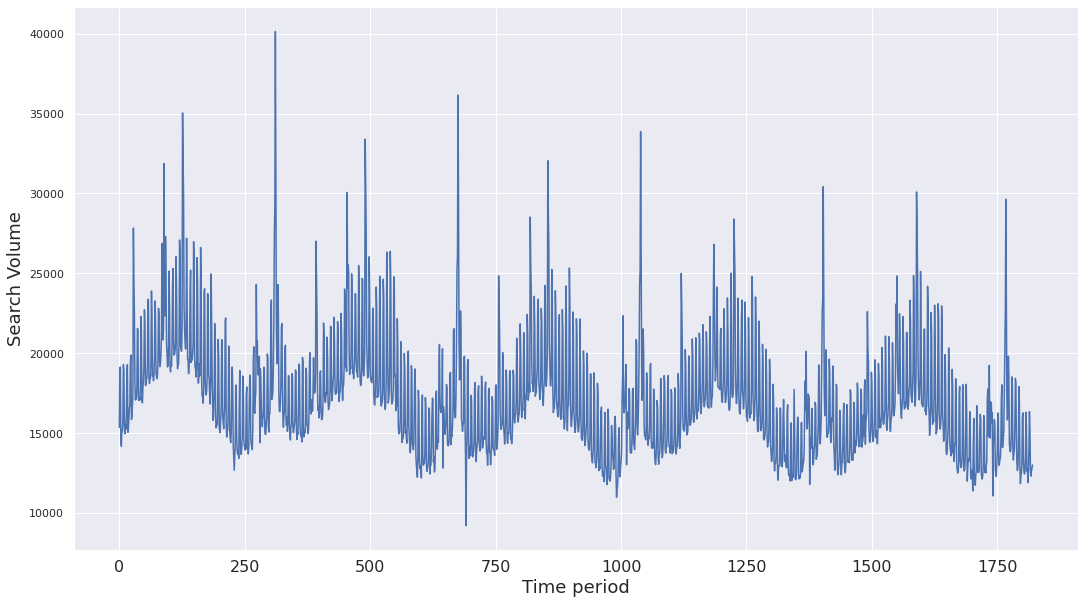

In [8]:
# Portraying the time series to capture elements of seasonality, trends and variation

df['value'].plot(figsize = (18,10))
plt.xticks(fontsize=16)
plt.xlabel('Time period',fontsize=18)
plt.ylabel('Search Volume',fontsize=18)

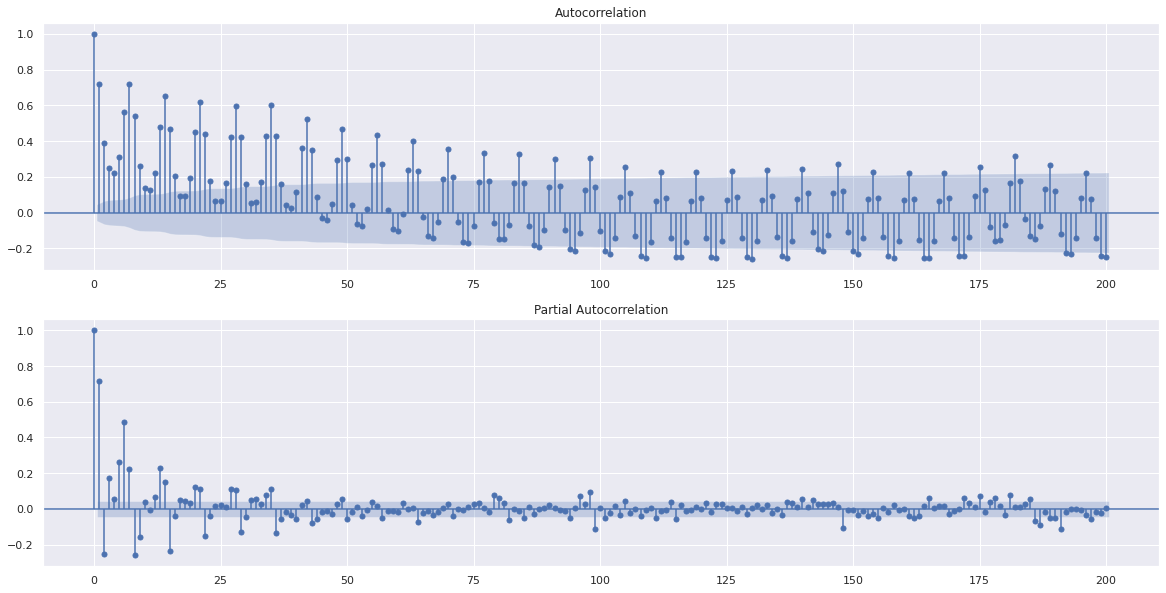

In [9]:
# Plotting the ACF and PACF, with a lag of 200 
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df['value'], lags=200, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['value'], lags=200, ax=ax[1])
plt.show()

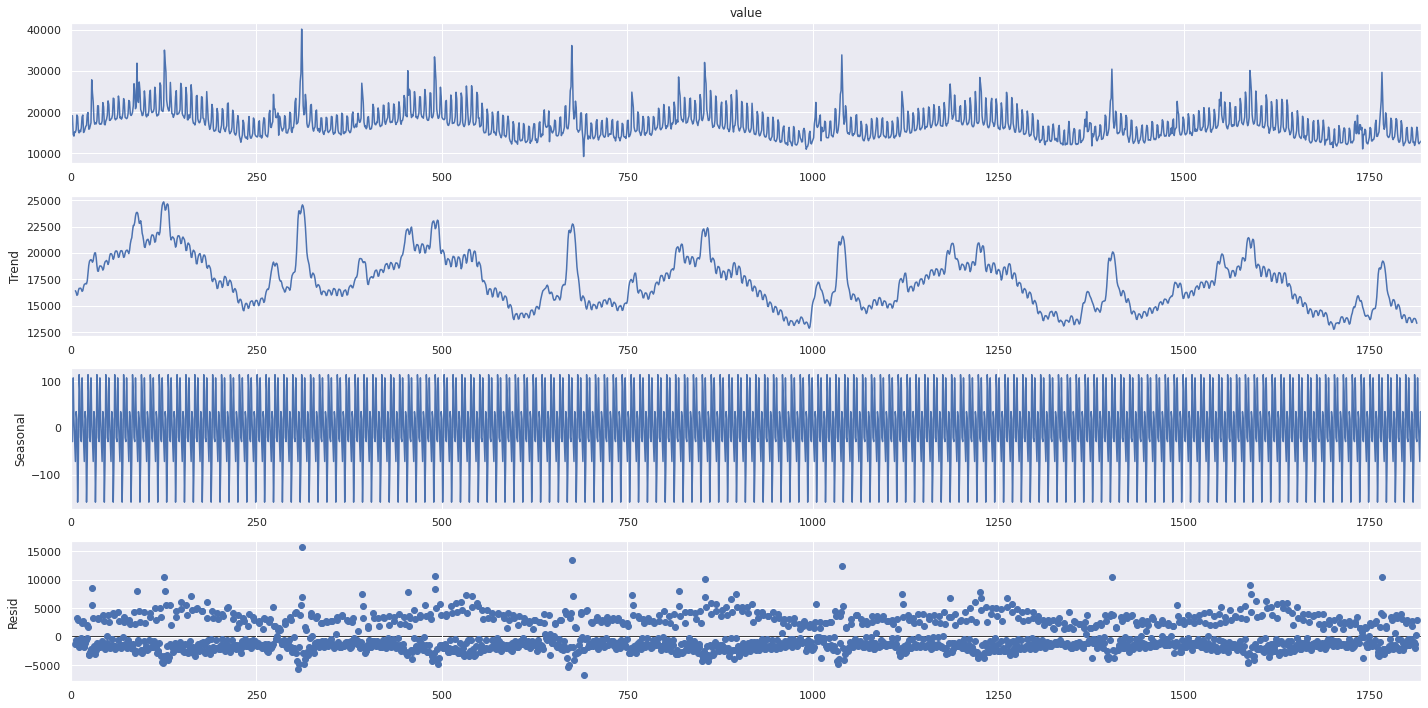

In [10]:
# Decomposition of the time series to identify non-stationary elements of the series
plt.rcParams['figure.figsize'] = [20,10]
res = sm.tsa.seasonal_decompose(df.value,period=12)
res.plot();

#### Converting the daily data to monthly format, by adding up the number of searches

In [11]:
# Converting the timestamp to a year-month format
df.period = df.period.dt.strftime('%Y-%m')

In [12]:
df = df.sort_values('period').reset_index(drop=True)

In [13]:
# Adding up the number of searches by year and month
df = df.groupby('period').sum()

In [14]:
df.tail()

,value
period,
2018-06,643060.751612
2018-07,661369.857004
2018-08,588109.482962
2018-09,526488.755961
2018-10,15348.962257


In [15]:
# '2018-10' is potentially an outlier as the total number of searches are drastically low since we have data only 
# for the first day of October 2018
df = df.iloc[:-1,:]

In [16]:
df.index = pd.to_datetime(df.index, format='%Y-%m')

In [17]:
# Creating a copy of the dataframe for plotting purposes
df_plot = df.copy()
df_plot.reset_index(inplace=True)

In [18]:
df_plot.set_index("period",inplace=True)
df_plot.head()

,value
period,
2013-10-01,336765.807461
2013-11-01,492954.139570
2013-12-01,461523.781137
2014-01-01,432588.960062
2014-02-01,389052.059952


Text(0.5, 0, 'Time period')

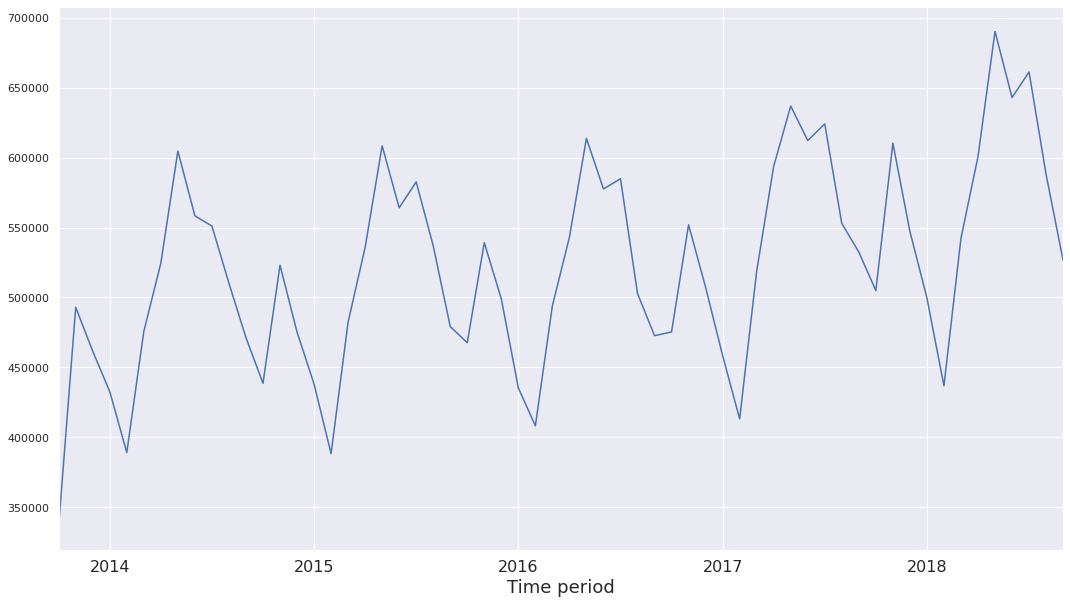

In [19]:
# Plotting the monthly time-series
df['value'].plot(figsize = (18,10))
plt.xticks(fontsize=16)
plt.xlabel('Time period',fontsize=18)

Text(0, 0.5, 'Search Volume')

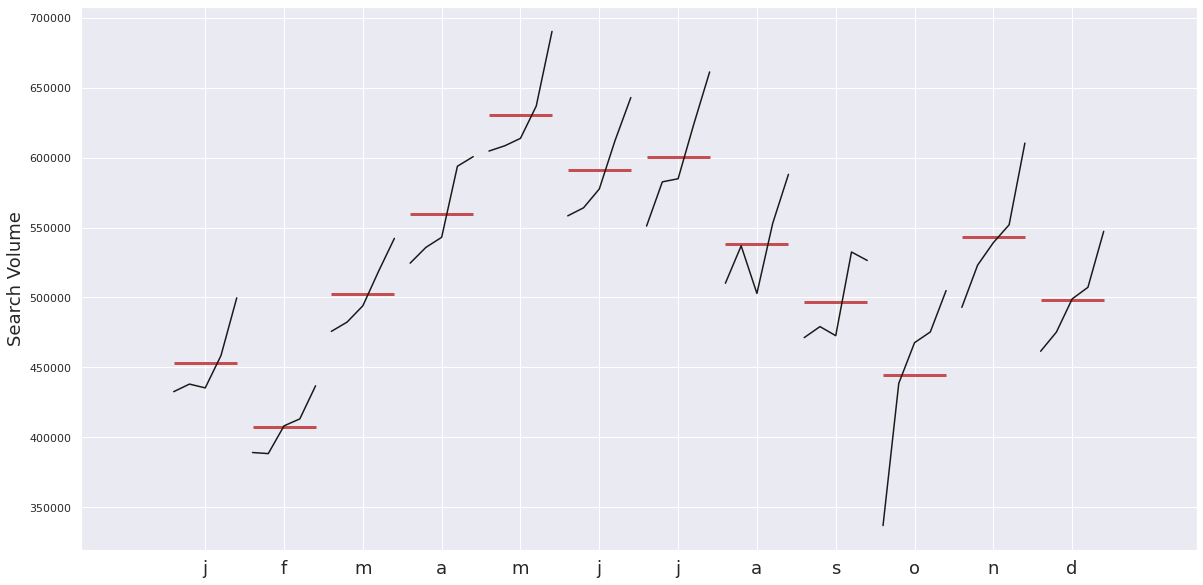

In [20]:
# After converting the data into monthly format, we create a month-plot from which we can observe the seasonal patterns better
month_plot(df_plot["value"]);
plt.xticks(fontsize=18)
plt.ylabel('Search Volume',fontsize=18)

In [21]:
# As we see, the monthy data does possess an upward trend, slight variation and seasonal persistence.
# We perform our first transformation on the data to remove the variation by taking a log of the 'values'
df['log_value'] = df['value'].apply(lambda x : math.log(x))

<AxesSubplot:xlabel='period'>

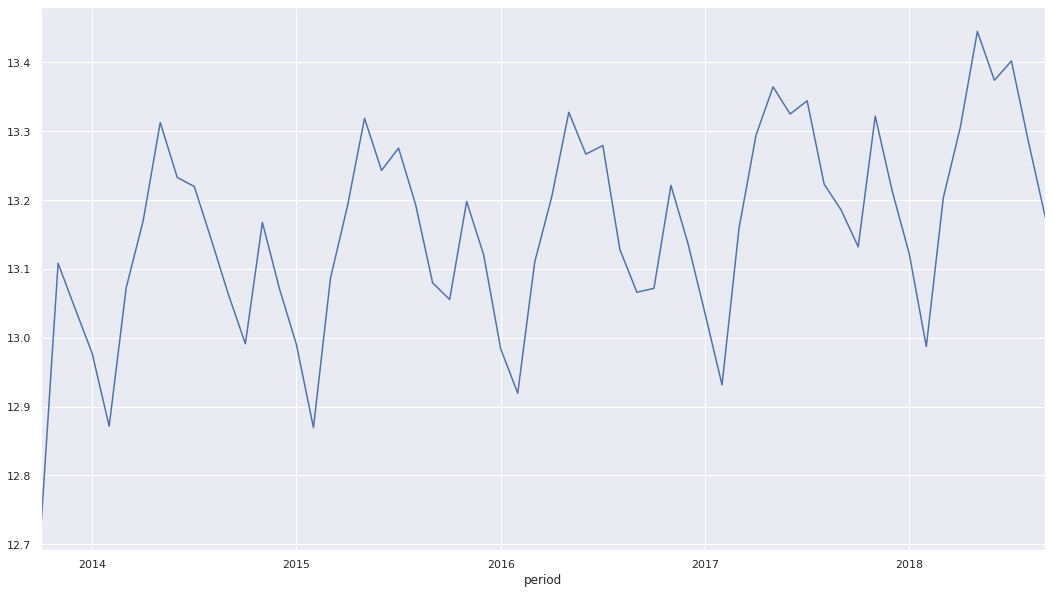

In [22]:
df['log_value'].plot(figsize = (18,10))

In [23]:
# Removing the upward trend by using the diff() operation
df['diff_log_value'] = df['log_value'].diff()

<AxesSubplot:xlabel='period'>

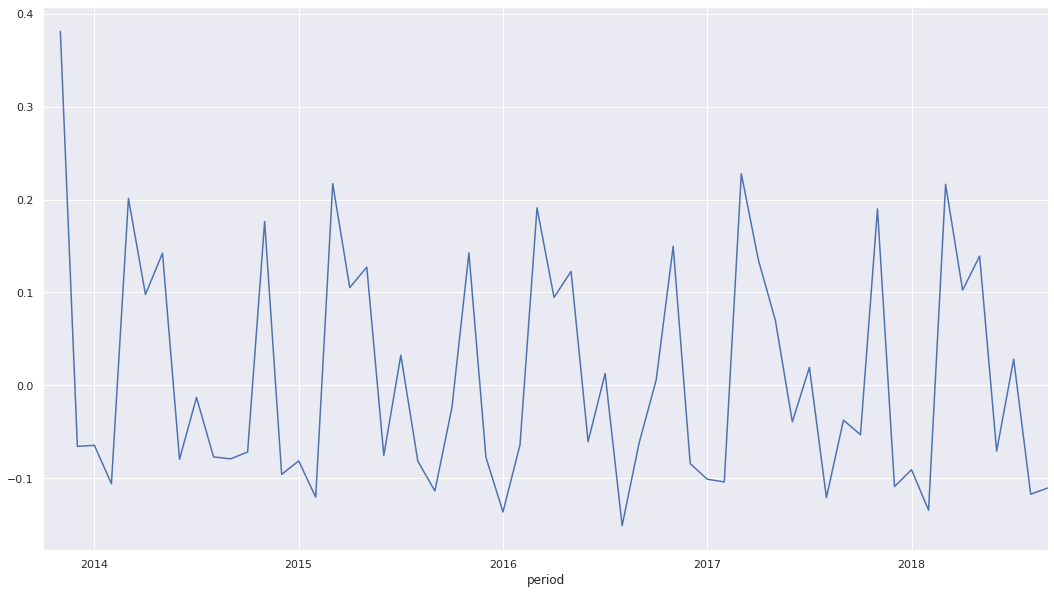

In [24]:
# The below plot shows that our dataset is now free of any trend and variation, however it still possesses some seasonality
df['diff_log_value'].plot(figsize = (18,10))

/home/nihar/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0, 0.5, 'Search Volume')

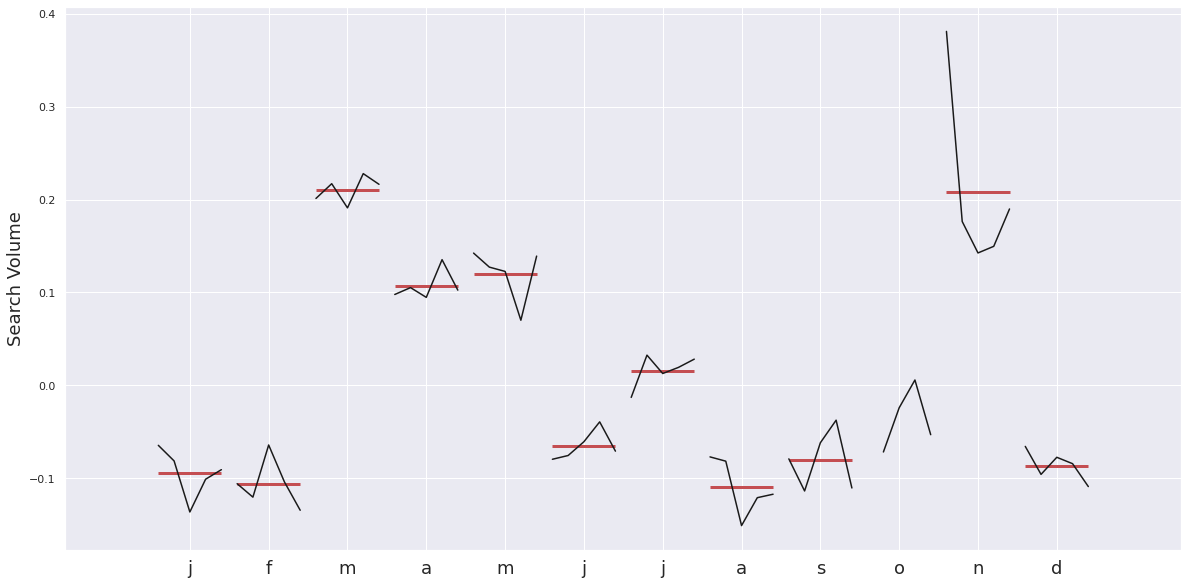

In [25]:
month_plot(df["diff_log_value"]);
plt.xticks(fontsize=18)
plt.ylabel('Search Volume',fontsize=18)

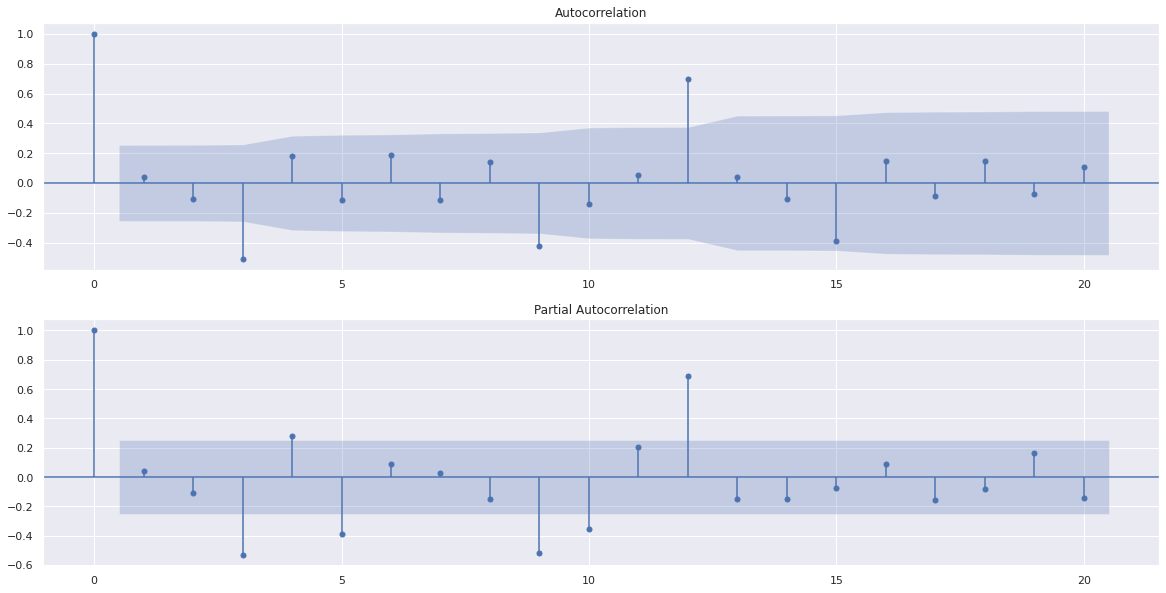

In [26]:
# ACF and PACF plot, of the search values after performing log and diff operations 
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df.loc[:,['diff_log_value']].dropna(), lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df.loc[:,['diff_log_value']].dropna(), lags=20, ax=ax[1])
plt.show()

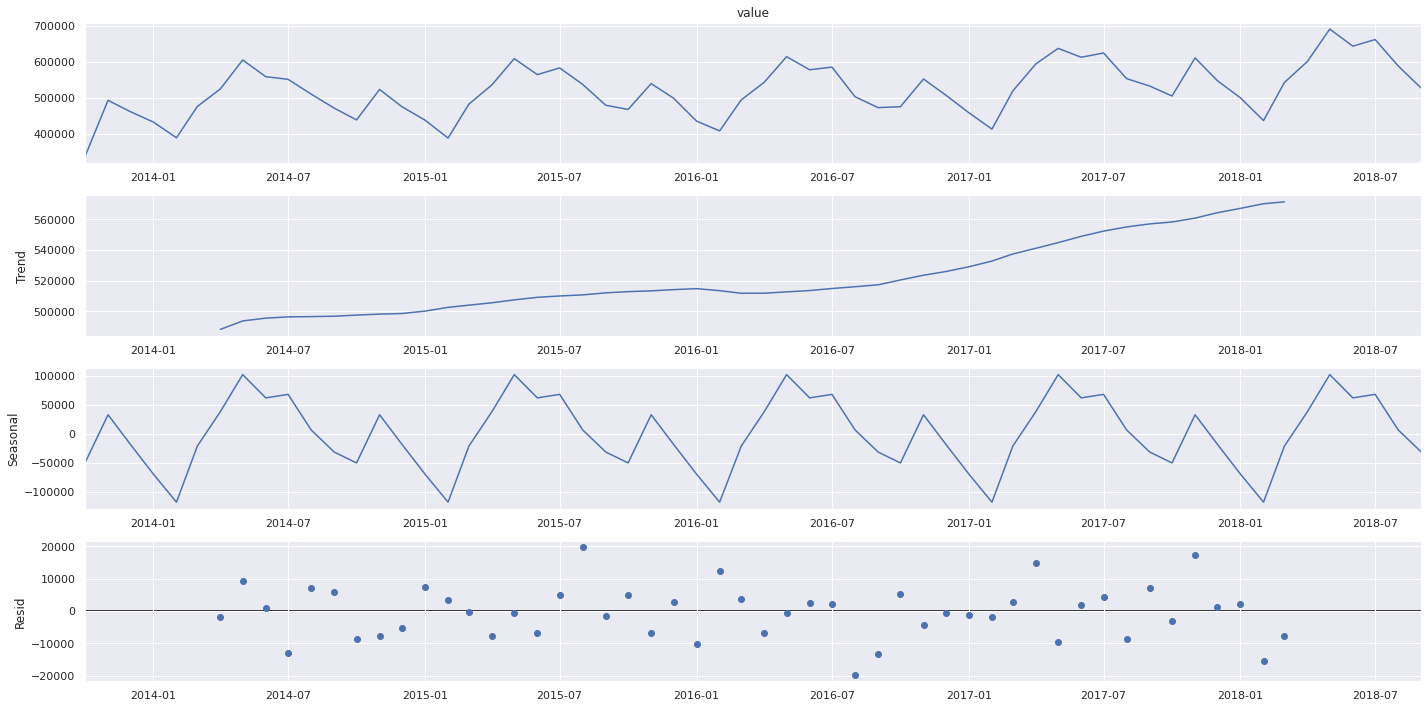

In [27]:
# A breakdown of the time series using seasonal decomposition
plt.rcParams['figure.figsize'] = [20,10]
res = sm.tsa.seasonal_decompose(df.value,period=12)
res.plot();

In [28]:
# Getting rid of the seasonality in the data by differentiaing the search values in periods of 12
df['season_diff_log_value'] = df['log_value'].diff(periods=12)

### Confirming stationarity of the refined time series using Augmented Dickey-Fuller test

In [29]:
df_adf = df.copy()
df_adf.dropna(inplace=True)
df_adf.head()

,value,log_value,diff_log_value,season_diff_log_value
period,,,,
2014-10-01,438579.331526,12.991296,-0.071908,0.264153
2014-11-01,523124.776878,13.167575,0.176279,0.059404
2014-12-01,475230.696921,13.071556,-0.096020,0.029267
2015-01-01,438019.953760,12.990020,-0.081536,0.012476
2015-02-01,388279.128822,12.869480,-0.120540,-0.001989


In [30]:
# Performing the Augmented Dickey-Fuller test on the 'season_diff_log_value' column
X = df_adf['season_diff_log_value']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.290078
p-value: 0.015328


### As the resulting p-value = 0.015328 which is <= 0.05, we reject the Null Hypothesis and accept the Alternate  Hypothesis. This suggests the time series does not have a unit root, meaning it is stationary. It does not have any time-dependent structure.

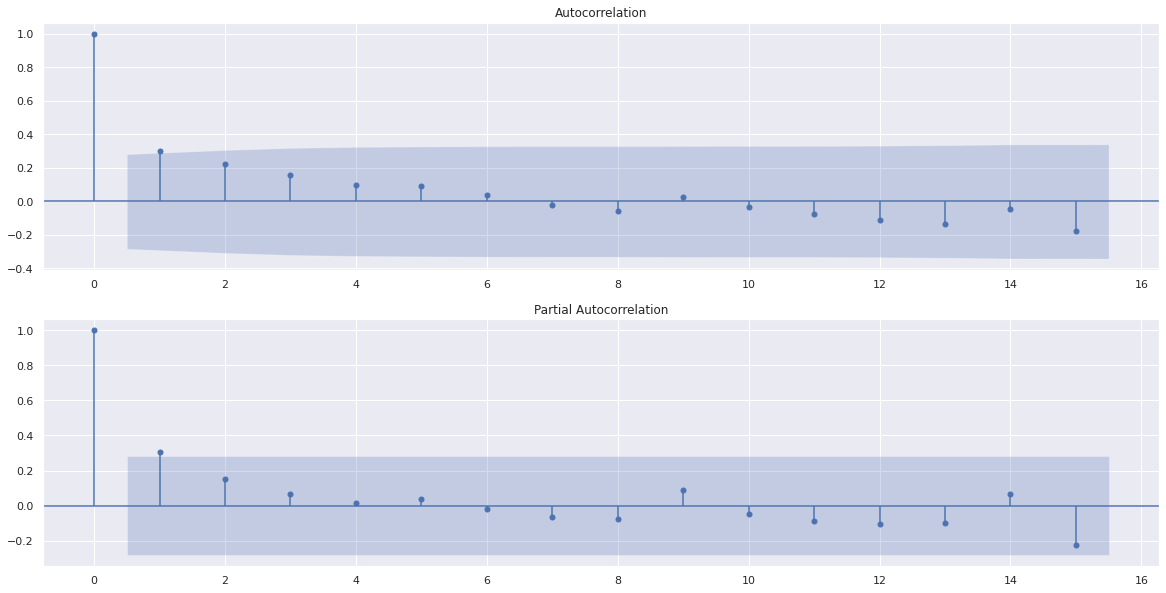

In [31]:
# PLotting the ACF and PACF of the transformed series for model diagnosis and model-fitting
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df.loc[:,['season_diff_log_value']].dropna(), lags=15, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df.loc[:,['season_diff_log_value']].dropna(), lags=15, ax=ax[1])
plt.show()

In [32]:
df_mplot = df.dropna()
df_mplot.head()

,value,log_value,diff_log_value,season_diff_log_value
period,,,,
2014-10-01,438579.331526,12.991296,-0.071908,0.264153
2014-11-01,523124.776878,13.167575,0.176279,0.059404
2014-12-01,475230.696921,13.071556,-0.096020,0.029267
2015-01-01,438019.953760,12.990020,-0.081536,0.012476
2015-02-01,388279.128822,12.869480,-0.120540,-0.001989


Text(0, 0.5, 'Search Volume')

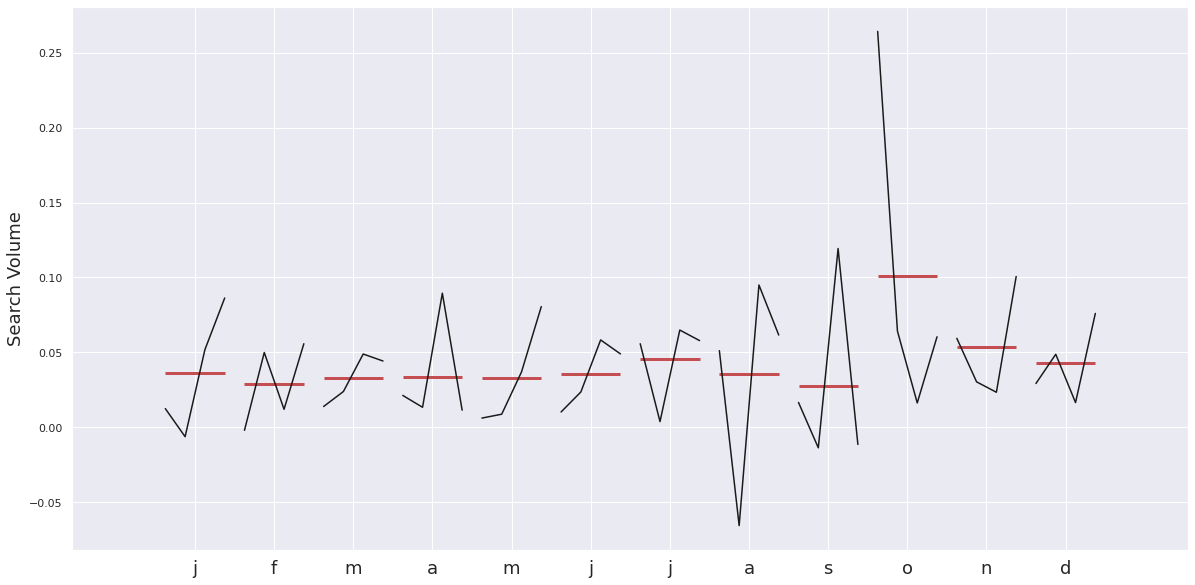

In [33]:
# The month-plot of the transformed time-series suggests that the data no longer has an seasonality and number of 
# searches are same across months on an average.
month_plot(df_mplot["season_diff_log_value"]);
plt.xticks(fontsize=18)
plt.ylabel('Search Volume',fontsize=18)

### Train Test Split

In [34]:
# Splitting the data into 80% Train and 20% Train
val = int(len(df)*0.8)
train = df.iloc[:val,:]
test = df.iloc[val:,:]

In [35]:
train.head()

,value,log_value,diff_log_value,season_diff_log_value
period,,,,
2013-10-01,336765.807461,12.727143,NaN,NaN
2013-11-01,492954.139570,13.108171,0.381028,NaN
2013-12-01,461523.781137,13.042289,-0.065883,NaN
2014-01-01,432588.960062,12.977543,-0.064746,NaN
2014-02-01,389052.059952,12.871468,-0.106075,NaN


In [36]:
test.head()

,value,log_value,diff_log_value,season_diff_log_value
period,,,,
2017-10-01,504912.590682,13.132141,-0.053277,0.060394
2017-11-01,610452.002612,13.321955,0.189814,0.100633
2017-12-01,547327.384843,13.212802,-0.109153,0.075987
2018-01-01,499744.236036,13.121852,-0.090951,0.086272
2018-02-01,436783.186156,12.987192,-0.134660,0.055763


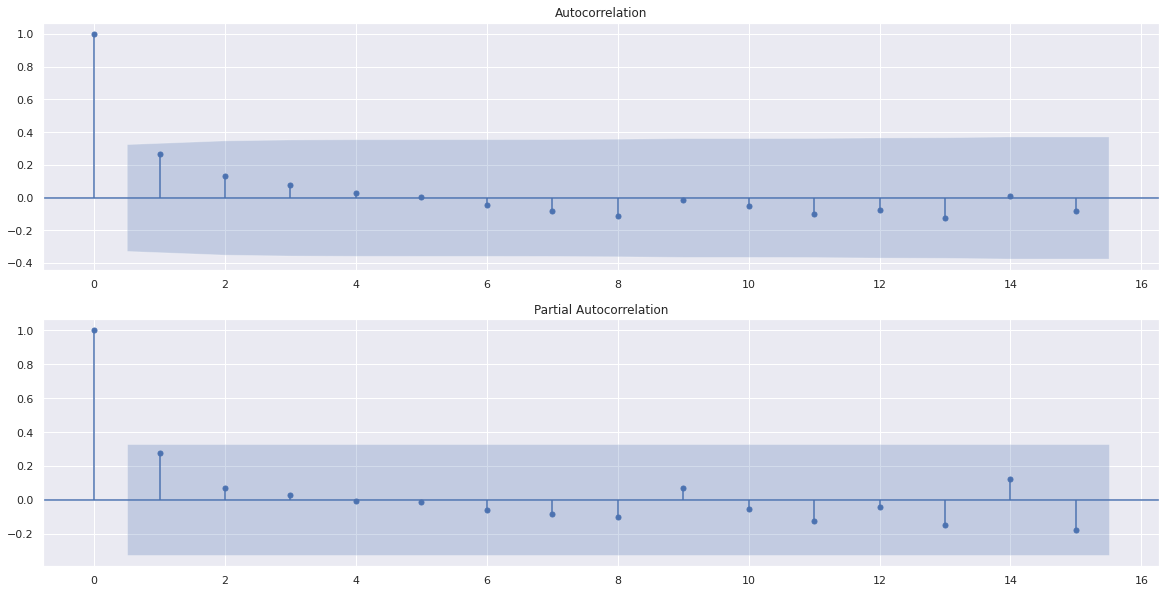

In [37]:
# Plotting ACF and PACF of the training set
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.loc[:,['season_diff_log_value']].dropna(), lags=15, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.loc[:,['season_diff_log_value']].dropna(), lags=15, ax=ax[1])
plt.show()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


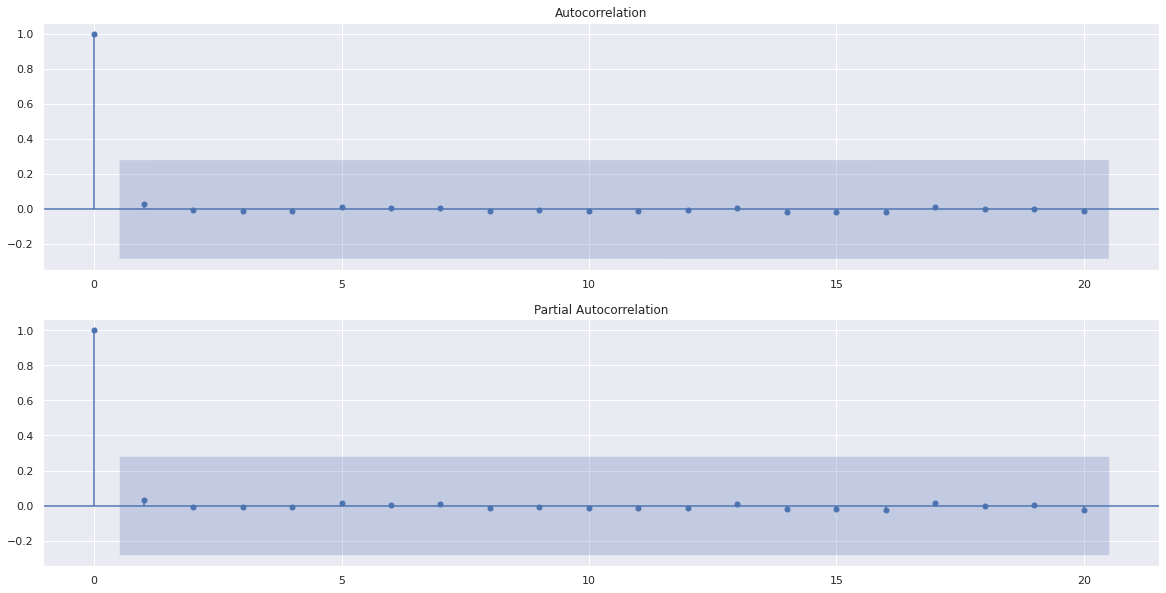

In [38]:
# Performing model fitting and diagnosis based on the above ACF and PACF plots.
# First we attempt to perform SARIMA (p,d,q) X (P,D,Q) -> SARIMA (0,1,0) X (0,0,0,12)
model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(0,0,0,12)).fit()
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [39]:
model.aic

-61.94886933021384

#### The AIC of SARIMA (0,1,0) X (0,0,0,12) is -61.9488

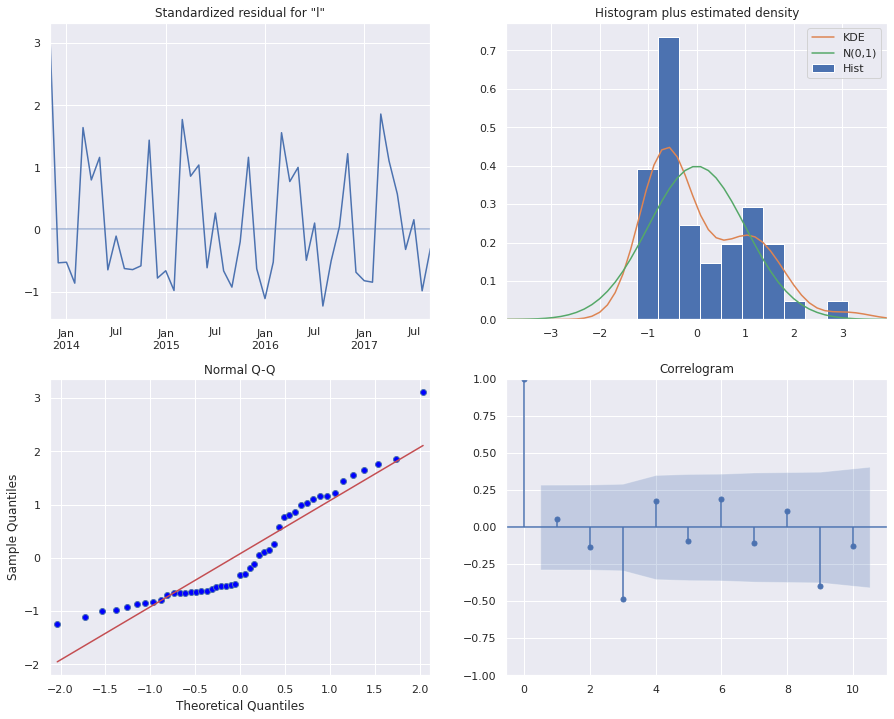

Ljung-box p-values:
[0.69636057 0.57440022 0.00409075 0.00492855 0.00896595 0.00799694
 0.01169465 0.01628651 0.00079262]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log_value   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  31.974
Date:                Sun, 27 Mar 2022   AIC                            -61.949
Time:                        21:54:51   BIC                            -60.099
Sample:                    10-01-2013   HQIC                           -61.253
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0150      0.003      5.171      0.000       0.009       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 6.02
Prob(Q):                              0.70   Prob(JB):                         0.05
Heteroskedasticity (H):               0.54   Skew:                             0.88
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Perfroming Model Diagnosis
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


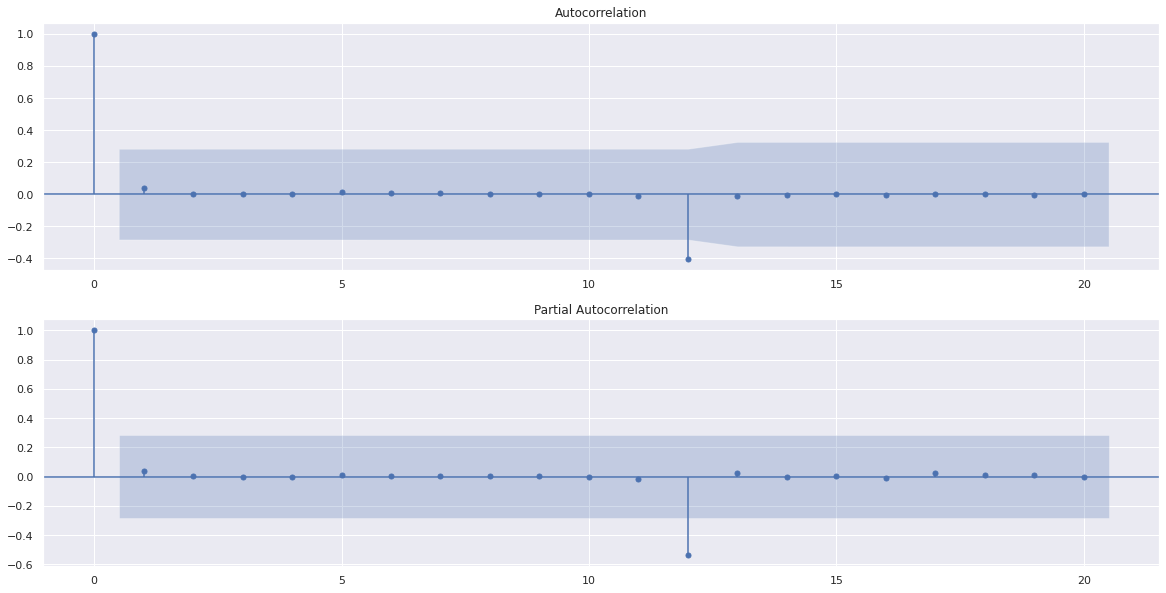

In [41]:
# Trying out SARIMA (p,d,q) X (P,D,Q) -> SARIMA (0,1,0) X (0,1,0,12)
model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(0,1,0,12)).fit()
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [42]:
model.aic

-112.57674639015237

#### The AIC of SARIMA (0,1,0) X (0,1,0,12) is -112.5767

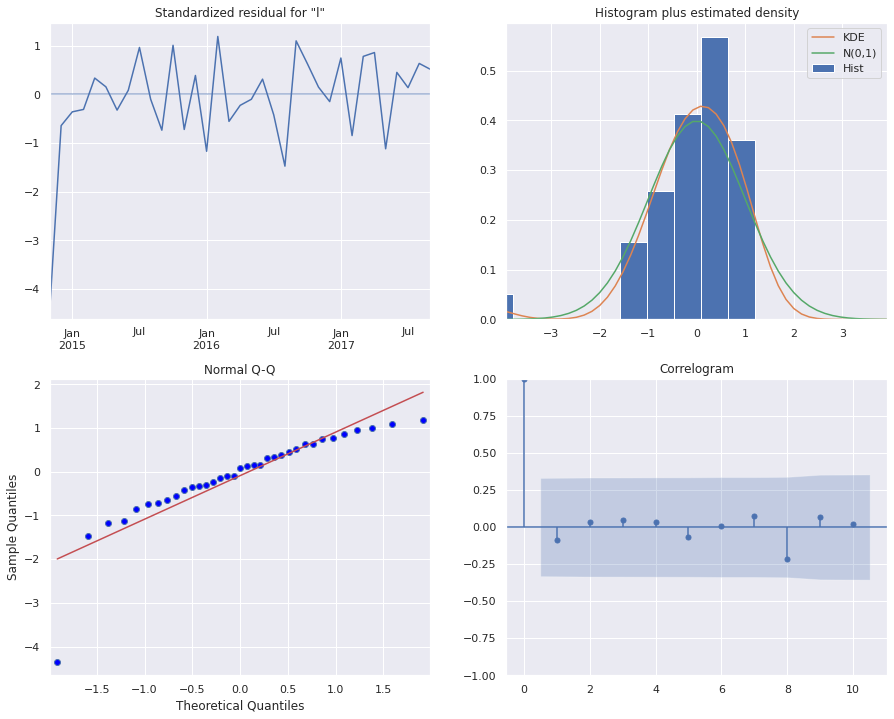

Ljung-box p-values:
[0.58046281 0.84252933 0.93415101 0.97488734 0.98352976 0.99462489
 0.99572757]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  57.288
Date:                            Sun, 27 Mar 2022   AIC                           -112.577
Time:                                    21:54:55   BIC                           -111.021
Sample:                                10-01-2013   HQIC                          -112.040
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0022      0.000      9.209      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                99.20
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# Perfroming Model Diagnosis
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


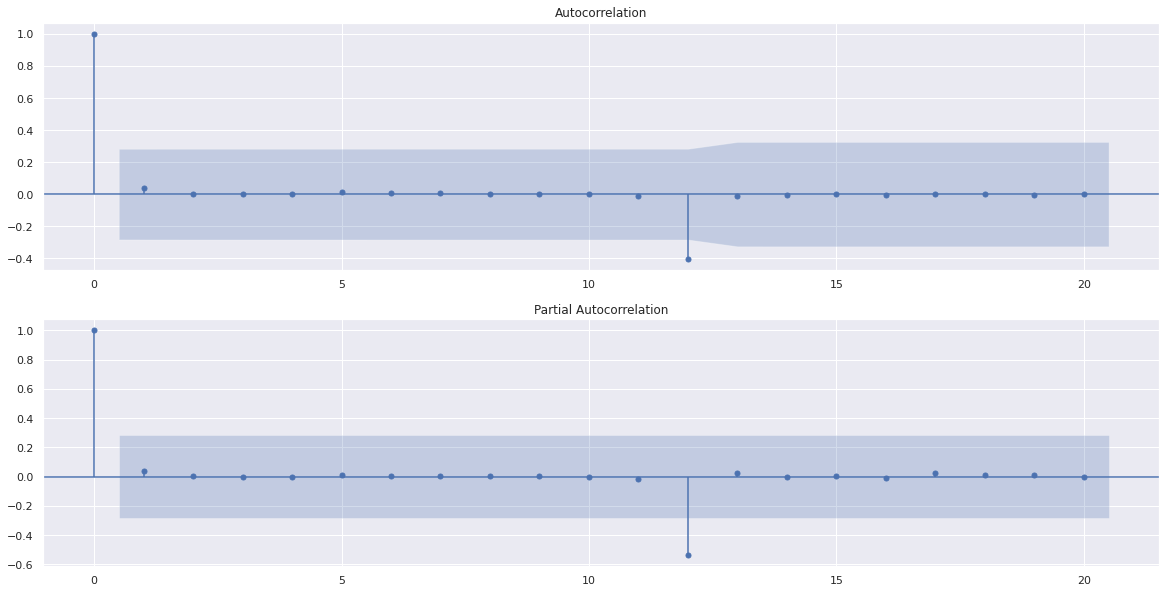

In [44]:
# Trying out SARIMA (p,d,q) X (P,D,Q) -> SARIMA (0,1,0) X (1,1,0,12)

model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(1,1,0,12)).fit()
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [45]:
model.aic

-110.58885931334794

#### The AIC of SARIMA (0,1,0) X (1,1,0,12) is -110.5888

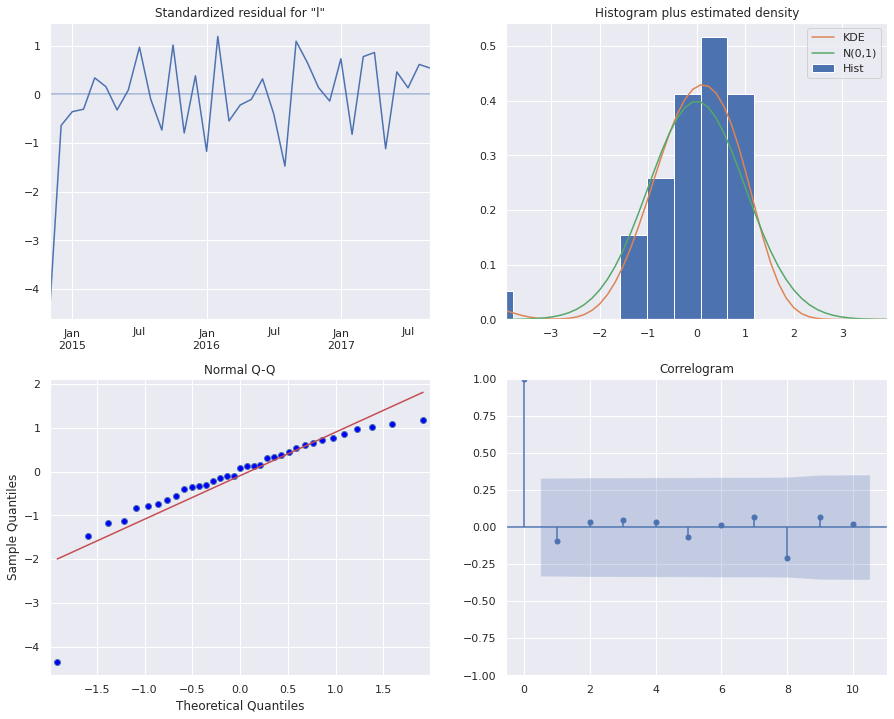

Ljung-box p-values:
[0.5741636  0.83552214 0.93148514 0.97459902 0.98377018 0.99468909
 0.99615501]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  57.294
Date:                            Sun, 27 Mar 2022   AIC                           -110.589
Time:                                    21:54:58   BIC                           -107.478
Sample:                                10-01-2013   HQIC                          -109.515
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0174      0.244     -0.071      0.943      -0.496       0.462
sigma2         0.0022      0.000      9.186      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                98.91
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Model Diagnosis
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


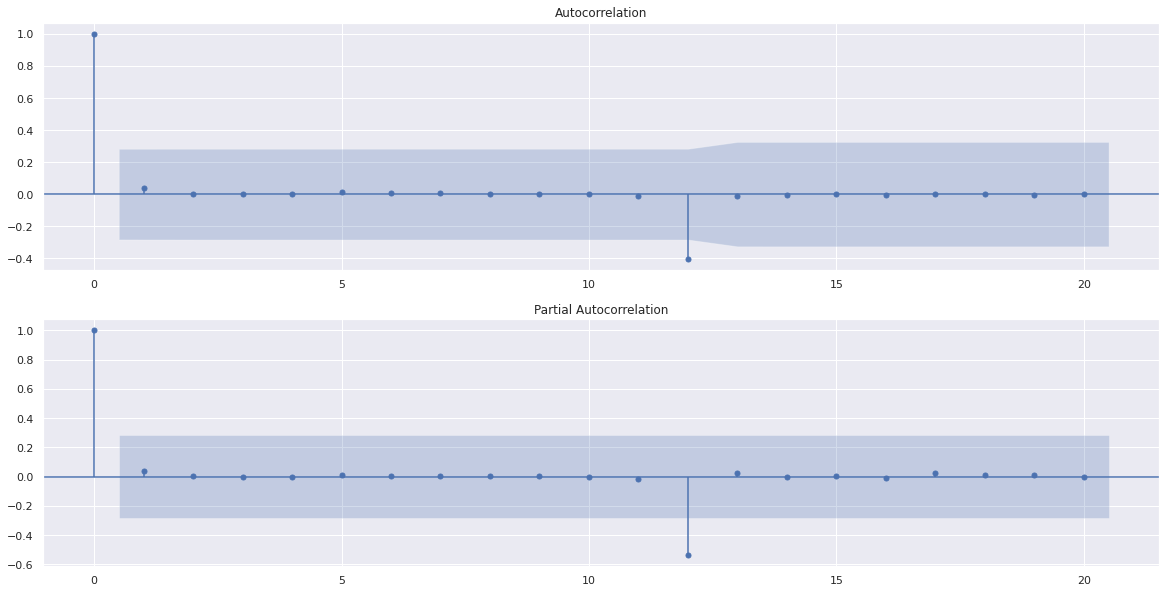

In [47]:
# Trying out SARIMA (p,d,q) X (P,D,Q) -> SARIMA (0,1,0) X (0,1,1,12)
model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(0,1,1,12)).fit()
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [48]:
model.aic

-110.5901762851646

#### The AIC of SARIMA (0,1,0) X (0,1,1,12) is -110.5905

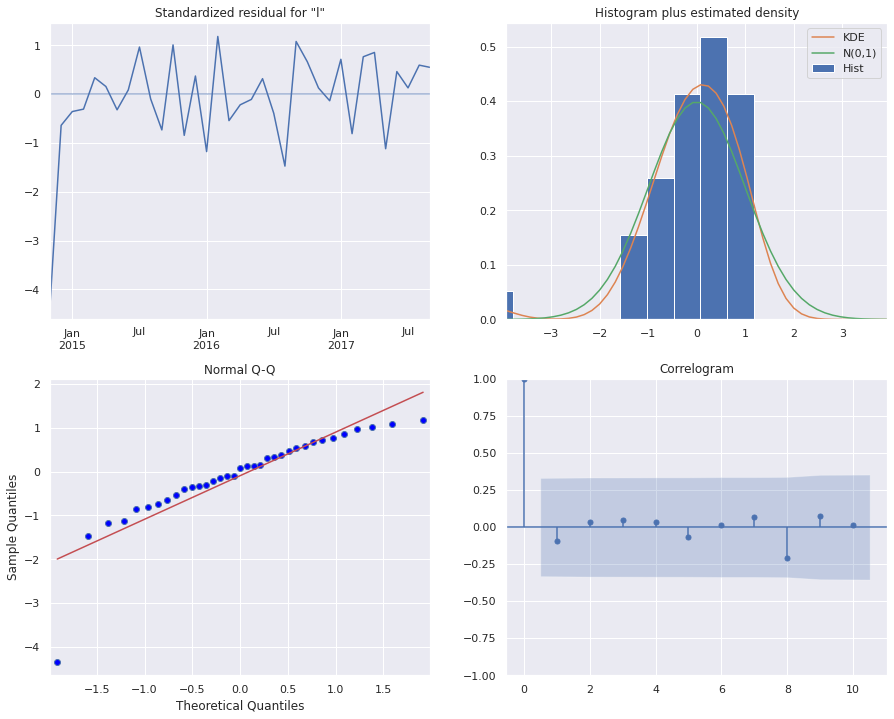

Ljung-box p-values:
[0.56943142 0.83060779 0.92939066 0.97422683 0.98378142 0.99466823
 0.99637722]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  57.295
Date:                              Sun, 27 Mar 2022   AIC                           -110.590
Time:                                      21:55:01   BIC                           -107.479
Sample:                                  10-01-2013   HQIC                          -109.516
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0291      0.236     -0.123      0.902      -0.491       0.433
sigma2         0.0022      0.000      9.106      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                98.54
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Model Diagnosis
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


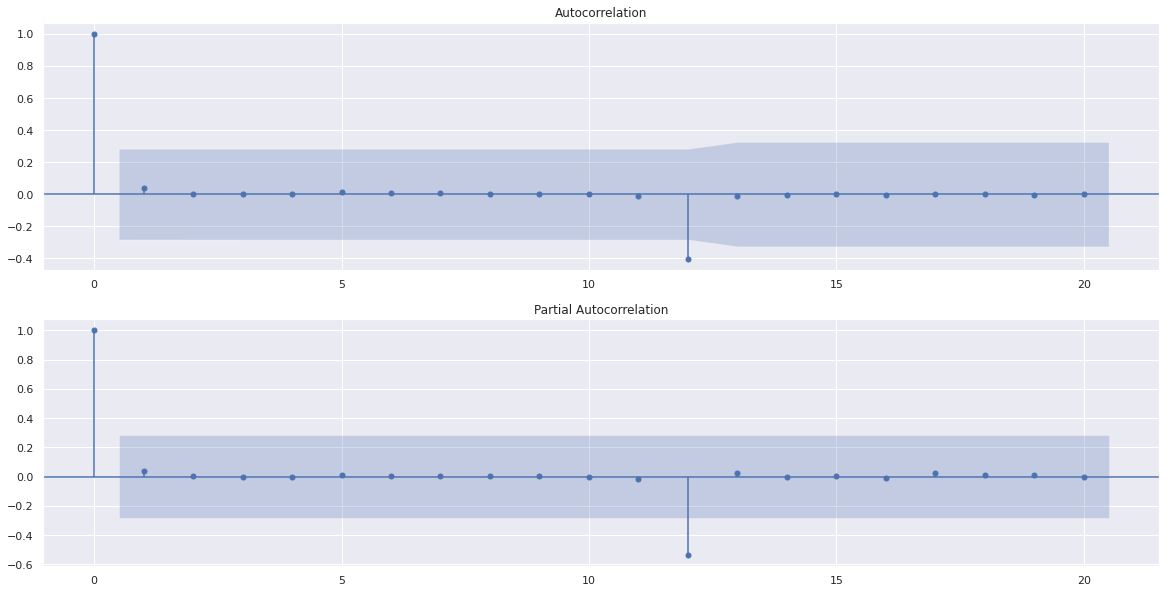

In [50]:
# Trying out SARIMA (p,d,q) X (P,D,Q) -> SARIMA (0,1,0) X (1,1,1,12)
model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(1,1,1,12)).fit()
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax[1])
plt.show()

In [51]:
model.aic

-108.59049762677556

#### The AIC of SARIMA (0,1,0) X (1,1,1,12) is -108.59053

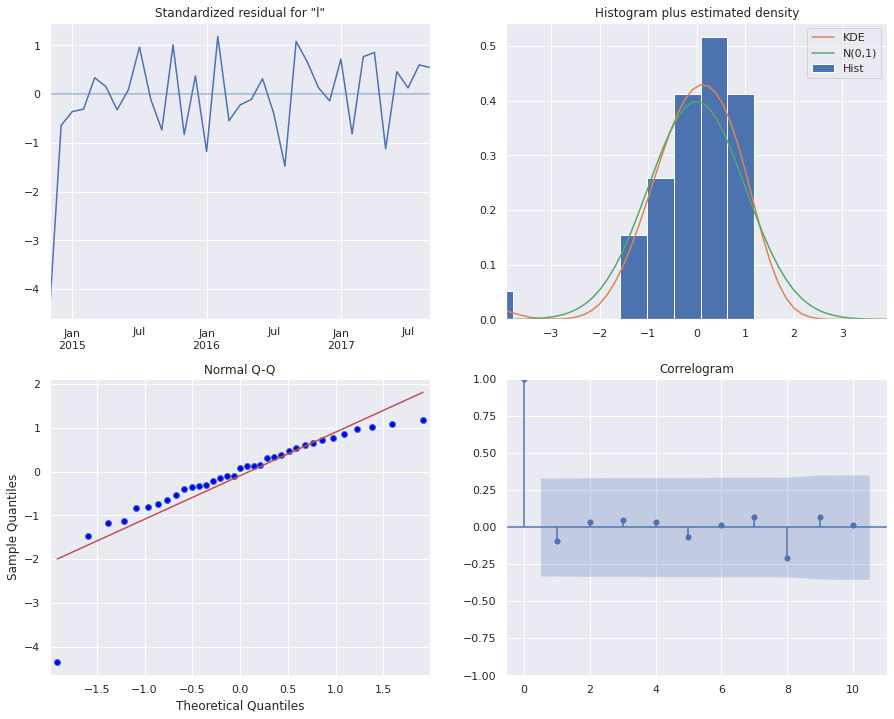

Ljung-box p-values:
[0.5712021  0.83235376 0.93018214 0.97438485 0.98380352 0.99468684
 0.99630701]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  57.295
Date:                              Sun, 27 Mar 2022   AIC                           -108.590
Time:                                      21:55:07   BIC                           -103.924
Sample:                                  10-01-2013   HQIC                          -106.980
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0117     43.428     -0.000      1.000     -85.129      85.106
ma.S.L12      -0.0133     43.464     -0.000      1.000     -85.202      85.175
sigma2         0.0022      0.000      9.159      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                98.69
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Model Diagnosis
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [53]:
# Choosing the model with minimum AIC, which is SARIMA (0,1,0) X (0,1,0,12)
model = sm.tsa.statespace.SARIMAX(train['log_value'], order=(0,1,0),seasonal_order=(0,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# Performing a forecast on the test data, having a time frame of 2017-10-01 - 2018-09-01
p = pd.DataFrame()
p['Forecast'] = model.predict(end='2018-09-01')[-12:].values
p['Actual'] = test['log_value'].values
p.index = test.index

(array([576]), [Text(0, 0, '')])

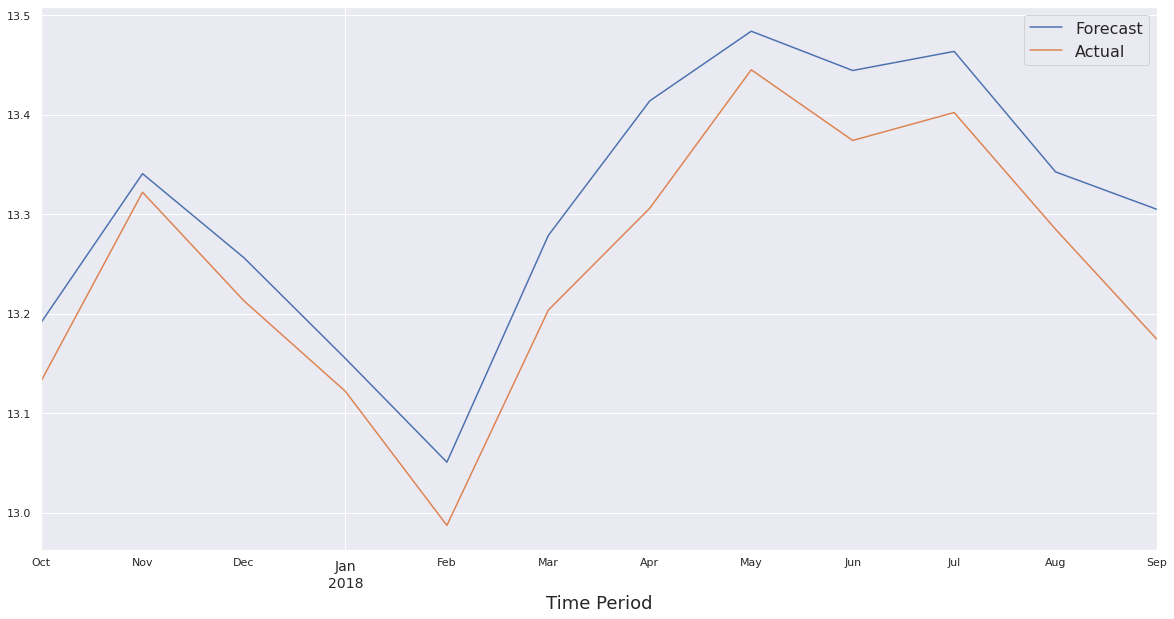

In [55]:
# The below line plot shows the comparison of the Forecast with the Actual values
p['Forecast'].plot(legend=True)
p['Actual'].plot(legend=True)
plt.xlabel('Time Period',fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)

In [56]:
# Calculating the Mean Square Error of the forecast
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(p['Actual'], p['Forecast'])
print('MSPE: %f' % mse)

MSPE: 0.004892


### Prophet

In [57]:
from prophet import Prophet

In [58]:
prophetdf= pd.DataFrame()
prophetdf['y'] = train['log_value']
prophetdf['ds'] = pd.to_datetime(train.index, format='%Y-%m')
prophetdf = prophetdf.reset_index(drop=True)

In [59]:
prophetdf.head()

,y,ds
0,12.727143,2013-10-01
1,13.108171,2013-11-01
2,13.042289,2013-12-01
3,12.977543,2014-01-01
4,12.871468,2014-02-01


In [60]:
m = Prophet(seasonality_mode='multiplicative' )
m.fit(prophetdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
future = m.make_future_dataframe(periods=12,freq='MS')
pred = m.predict(future).loc[:,['ds','yhat']].iloc[-12:,:]
pred

,ds,yhat
48,2017-10-01,13.158118
49,2017-11-01,13.329349
50,2017-12-01,13.243244
51,2018-01-01,13.147581
52,2018-02-01,13.045996
53,2018-03-01,13.263988
54,2018-04-01,13.374704
55,2018-05-01,13.496502
56,2018-06-01,13.430521
57,2018-07-01,13.447654


In [62]:
pred['actual'] = test['log_value'].values
pred.index = pred.ds

In [63]:
pred = pred.loc[:,['yhat','actual']]

(array([576]), [Text(0, 0, '')])

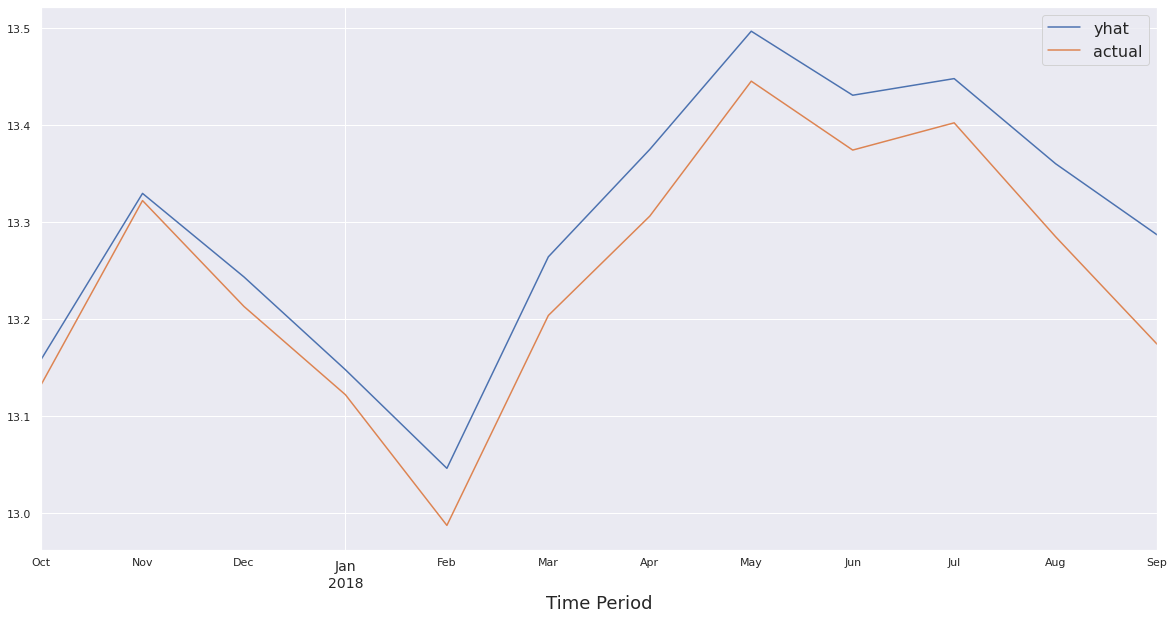

In [64]:
pred['yhat'].plot(legend=True)
pred['actual'].plot(legend=True)
plt.xlabel('Time Period',fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)

In [65]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(pred['actual'],pred['yhat'])
print('MSPE: %f' % mse)

MSPE: 0.003370


### Add Variable

In [67]:
df2.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.3,0.0,0.0,0.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,5128.7,1465.2,1211.8,171.9,348.3,0.0,0.0,238.2,1635.2,58.3,0.0
2,"WEEK OF OCT 07, 2013 (B)",Home Depot Home Center : Vignette,2.6,0.0,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"WEEK OF OCT 14, 2013 (B)",Home Depot Home Center & Kidde : Combo Vignette,6.1,0.0,0.0,0.0,6.1,0.0,0.0,0.0,0.0,0.0,0.0
4,"WEEK OF OCT 14, 2013 (B)",Home Depot Home Center : Home Center/Hardware ...,4760.4,1753.1,1105.8,91.1,116.9,0.0,0.0,0.0,1635.2,58.3,0.0


In [68]:
df2 = df2.loc[:,['TIME PERIOD','TOTAL DOLS (000)']]

In [69]:
df2['TIME PERIOD'] = df2['TIME PERIOD'].apply(lambda x: x[7:][:-4])

In [70]:
df2['TIME PERIOD'] = pd.to_datetime(df2['TIME PERIOD'])

In [71]:
df2['TIME PERIOD'] = df2['TIME PERIOD'].dt.strftime('%Y-%m')

In [72]:
df2 = df2.groupby('TIME PERIOD').sum()

In [73]:
df2.head()

,TOTAL DOLS (000)
TIME PERIOD,
2013-10,28099.7
2013-11,28823.8
2013-12,24891.3
2014-01,13118.6
2014-02,5676.2


In [74]:
df2 = df2.iloc[:-1,:]

<AxesSubplot:xlabel='TIME PERIOD'>

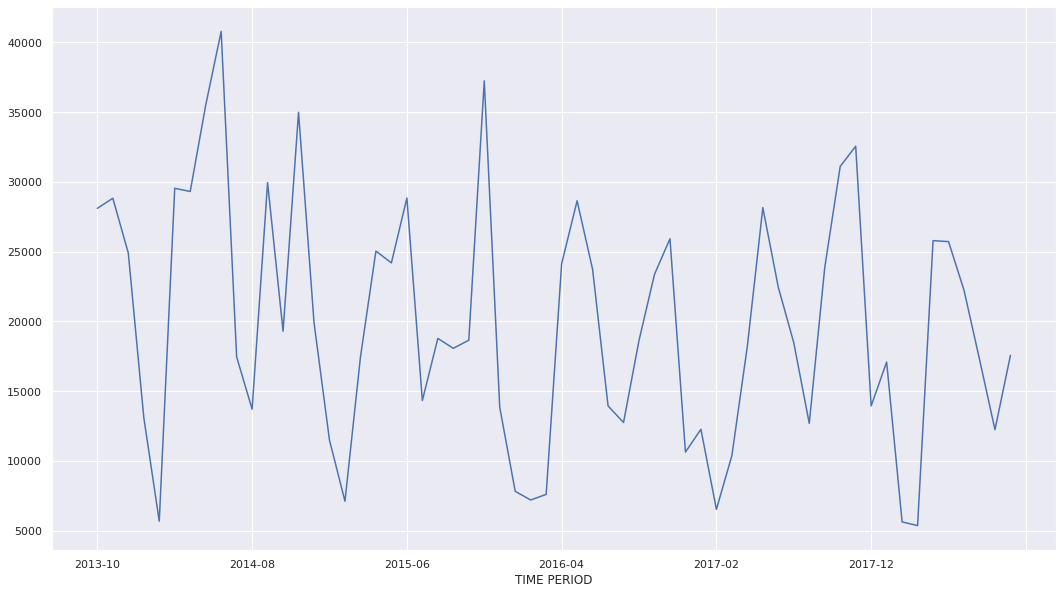

In [75]:
df2['TOTAL DOLS (000)'].plot(figsize = (18,10))

In [76]:
df2.index = pd.to_datetime(df2.index, format='%Y-%m')

In [77]:
df2.head()

,TOTAL DOLS (000)
TIME PERIOD,
2013-10-01,28099.7
2013-11-01,28823.8
2013-12-01,24891.3
2014-01-01,13118.6
2014-02-01,5676.2


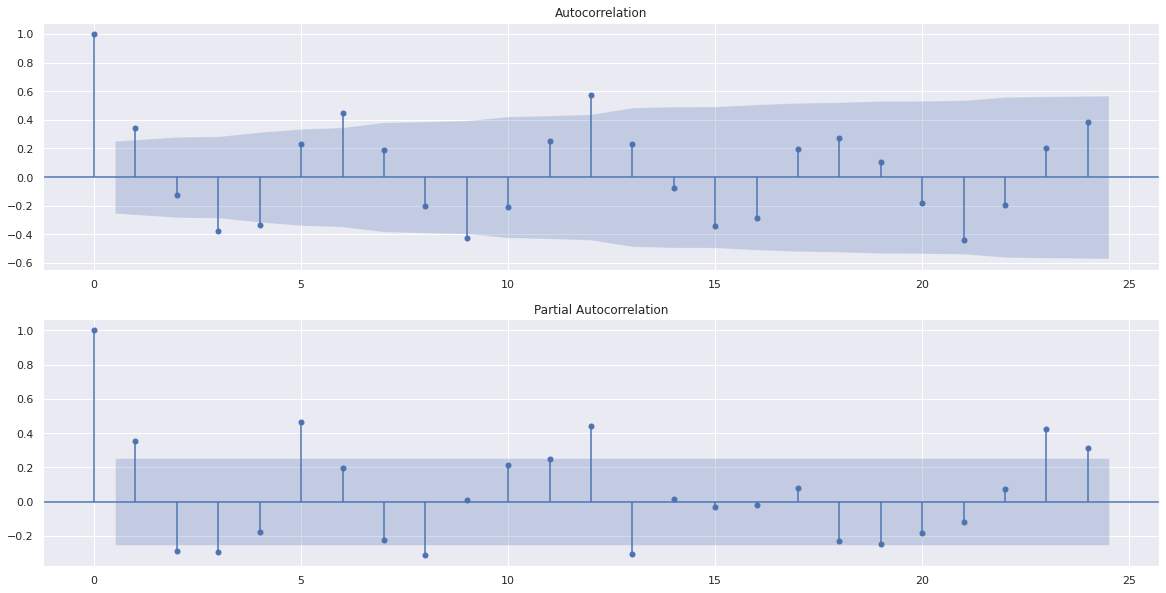

In [78]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df2.loc[:,['TOTAL DOLS (000)']].dropna(), lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df2.loc[:,['TOTAL DOLS (000)']].dropna(), lags=24, ax=ax[1])
plt.show()

In [79]:
df2['log_value'] = df2['TOTAL DOLS (000)'].apply(lambda x : math.log(x))

In [80]:
df2.head()

,TOTAL DOLS (000),log_value
TIME PERIOD,,
2013-10-01,28099.7,10.243514
2013-11-01,28823.8,10.268957
2013-12-01,24891.3,10.122274
2014-01-01,13118.6,9.481786
2014-02-01,5676.2,8.644037


<AxesSubplot:xlabel='TIME PERIOD'>

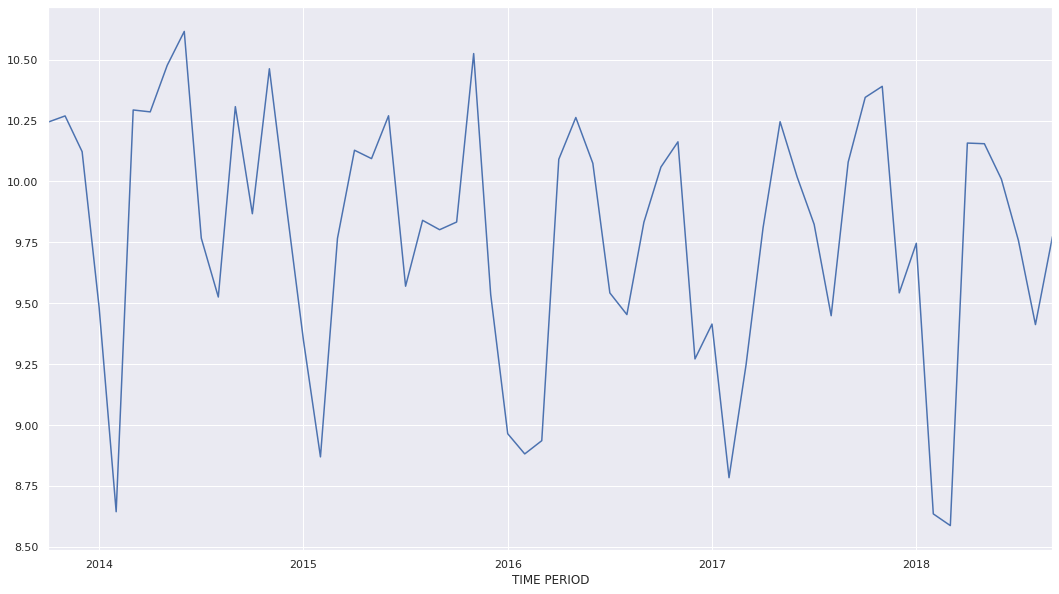

In [81]:
df2['log_value'].plot(figsize = (18,10))

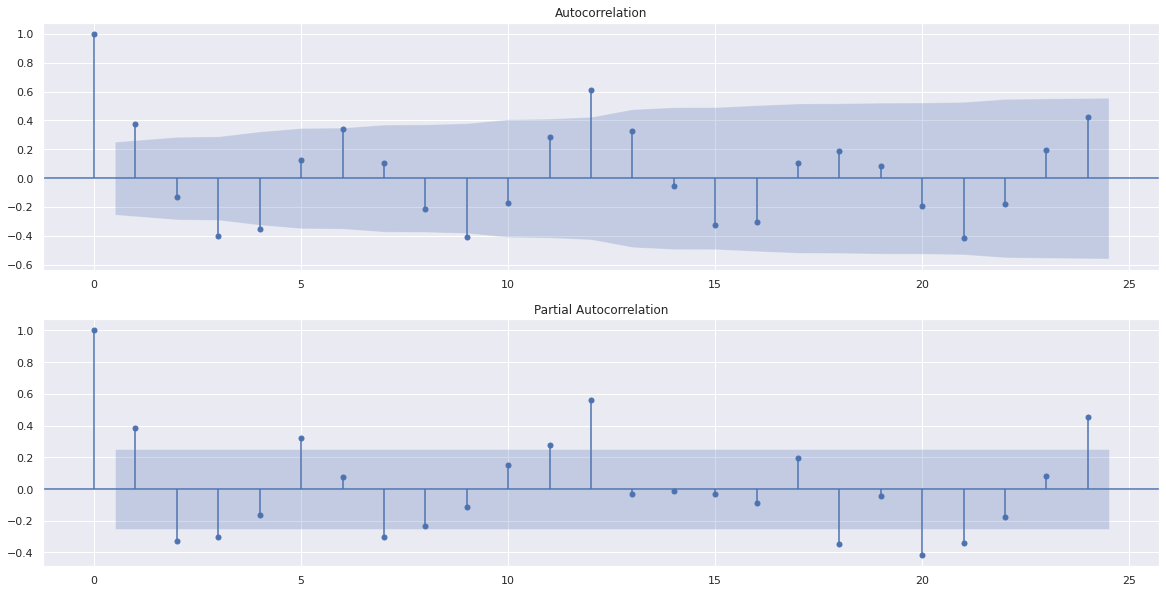

In [82]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df2.loc[:,['log_value']].dropna(), lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df2.loc[:,['log_value']].dropna(), lags=24, ax=ax[1])
plt.show()

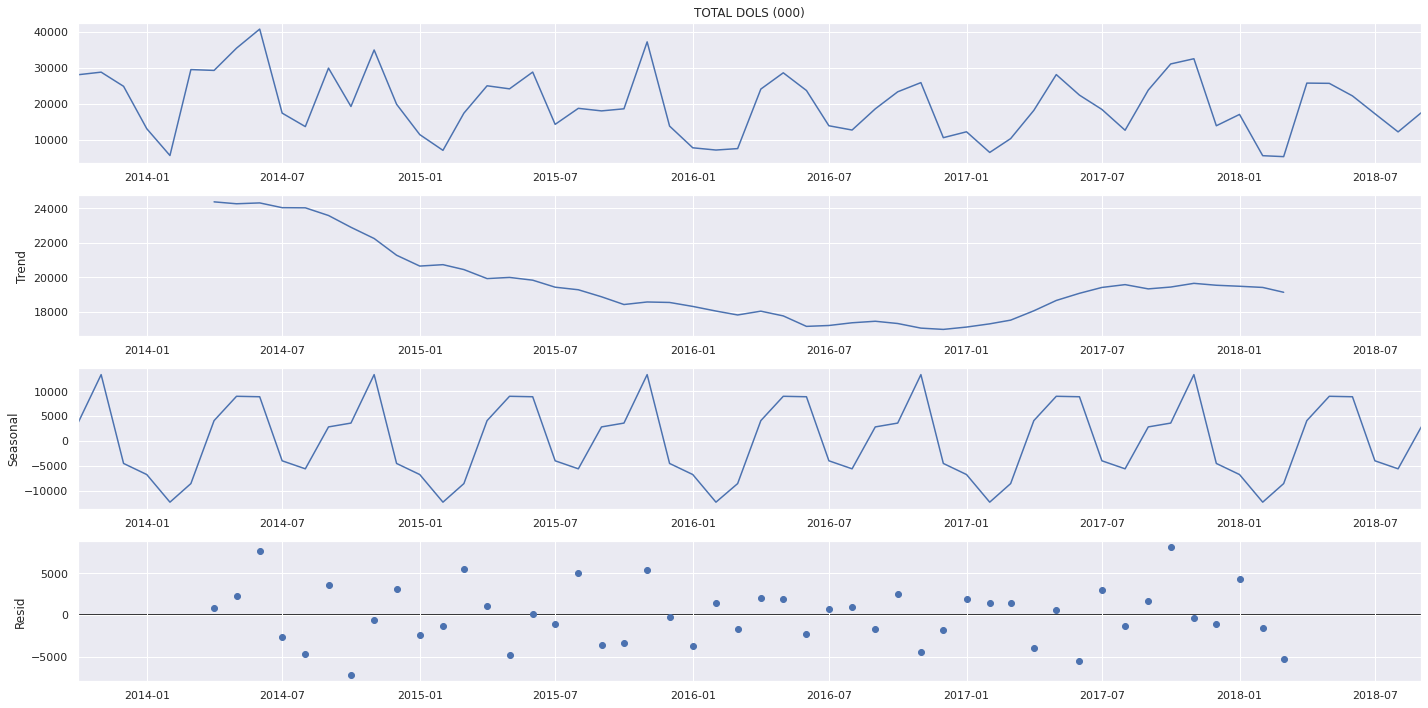

In [83]:
plt.rcParams['figure.figsize'] = [20,10]
res = sm.tsa.seasonal_decompose(df2['TOTAL DOLS (000)'],period=12)
res.plot();

## Train and Test split

In [84]:
train['log_total_sales'] = df2.iloc[:val,].log_value
train['total_sales'] = df2.iloc[:val,]['TOTAL DOLS (000)']
test['log_total_sales'] = df2.iloc[val:,].log_value
test['total_sales'] = df2.iloc[val:,]['TOTAL DOLS (000)']

<ipython-input-84-8fc10fab6aa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_total_sales'] = df2.iloc[:val,].log_value
<ipython-input-84-8fc10fab6aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['total_sales'] = df2.iloc[:val,]['TOTAL DOLS (000)']
<ipython-input-84-8fc10fab6aa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [85]:
test.tail()

,value,log_value,diff_log_value,season_diff_log_value,log_total_sales,total_sales
period,,,,,,
2018-05-01,690387.976951,13.445009,0.139052,0.080535,10.154834,25715.1
2018-06-01,643060.751612,13.373994,-0.071015,0.048999,10.009171,22229.4
2018-07-01,661369.857004,13.402069,0.028074,0.057868,9.757548,17284.2
2018-08-01,588109.482962,13.284668,-0.117400,0.061593,9.412309,12238.1
2018-09-01,526488.755961,13.173985,-0.110683,-0.011433,9.773760,17566.7


In [86]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['total_sales'], order=(0,1,0),seasonal_order=(0,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [87]:
model.aic

-20.335145694932795

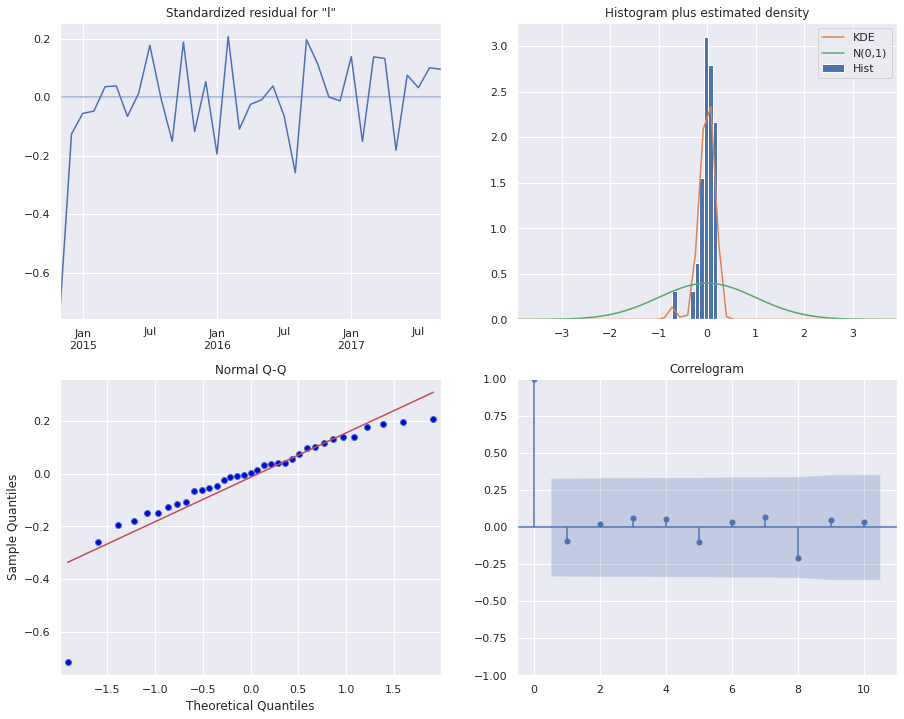

Ljung-box p-values:
[0.57528717 0.84903681 0.92414539 0.96390277 0.96177608 0.98322586
 0.98953802]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  12.168
Date:                            Sun, 27 Mar 2022   AIC                            -20.335
Time:                                    21:56:29   BIC                            -17.224
Sample:                                10-01-2013   HQIC                           -19.261
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
total_sales -4.299e-07   2.34e-05     -0.018      0.985   -4.63e-05    4.55e-05
sigma2          0.0772      0.027      2.876      0.004       0.025       0.130
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                75.74
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.93
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [89]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['total_sales'], order=(0,1,0),seasonal_order=(1,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
model.aic

-101.89245337822835

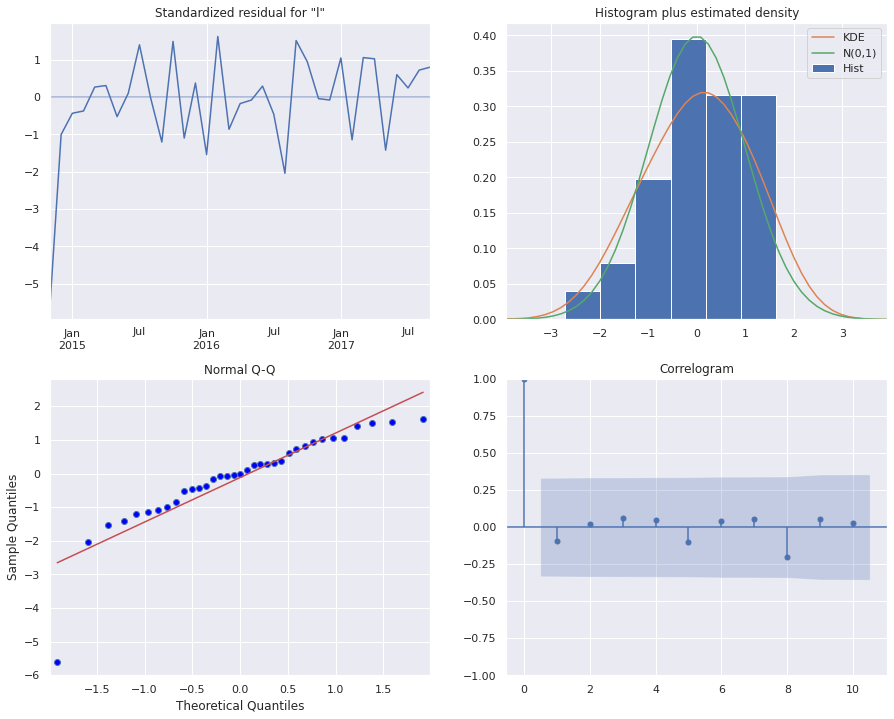

Ljung-box p-values:
[0.5627928  0.83743634 0.91897233 0.96363117 0.96162732 0.98248089
 0.99033945]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  53.946
Date:                            Sun, 27 Mar 2022   AIC                           -101.892
Time:                                    21:56:31   BIC                            -97.226
Sample:                                10-01-2013   HQIC                          -100.282
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
total_sales  -4.66e-07   7.24e-07     -0.644      0.520   -1.88e-06    9.53e-07
ar.S.L12       -0.0314      0.136     -0.231      0.817      -0.298       0.235
sigma2          0.0012      0.000      8.012      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                73.46
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.92
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [92]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['total_sales'], order=(0,1,0),seasonal_order=(0,1,1,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [93]:
model.aic

-108.75021932649106

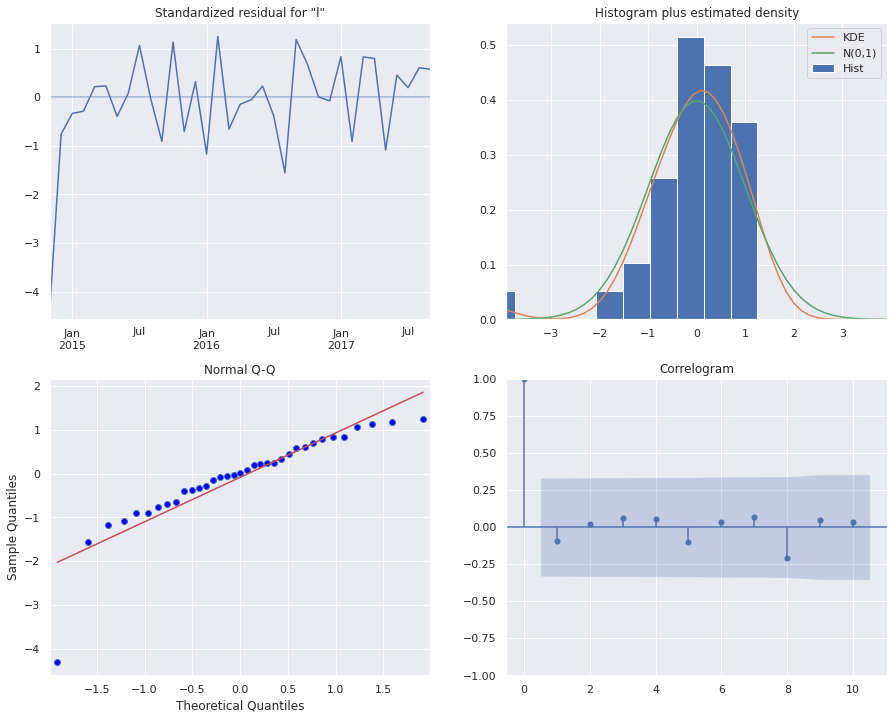

Ljung-box p-values:
[0.57528733 0.84903692 0.92414545 0.9639028  0.96177611 0.98322587
 0.98953803]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  57.375
Date:                              Sun, 27 Mar 2022   AIC                           -108.750
Time:                                      21:56:32   BIC                           -104.084
Sample:                                  10-01-2013   HQIC                          -107.140
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
total_sales -4.299e-07   1.27e-06     -0.338      0.735   -2.92e-06    2.06e-06
ma.S.L12             0      0.258          0      1.000      -0.506       0.506
sigma2          0.0021      0.000      4.576      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                75.74
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.93
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [95]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['total_sales'], order=(0,1,0),seasonal_order=(1,1,1,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
model.aic

-106.75021932649106

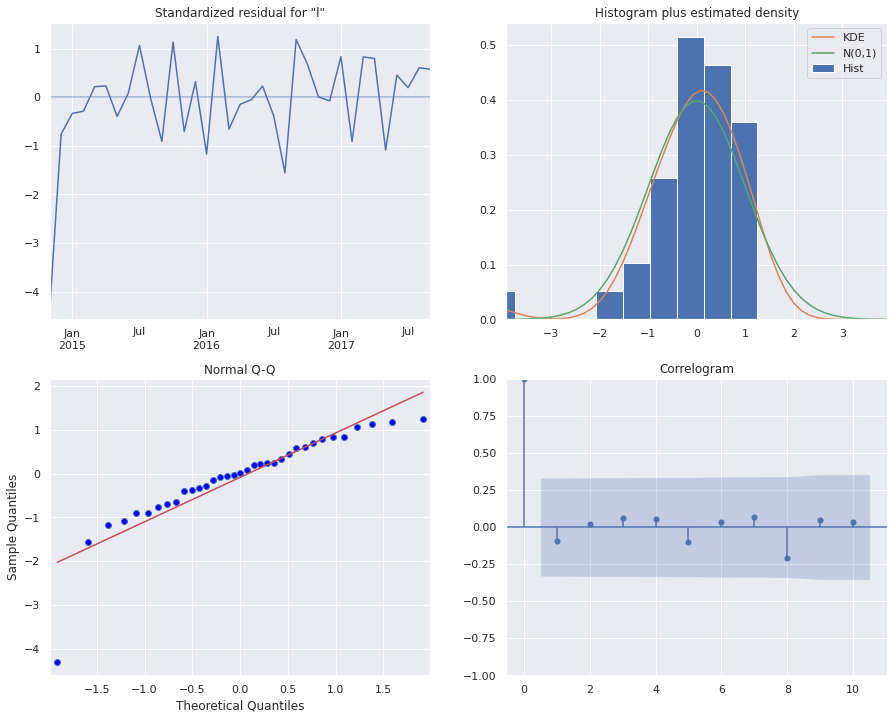

Ljung-box p-values:
[0.57528733 0.84903692 0.92414545 0.9639028  0.96177611 0.98322587
 0.98953803]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  57.375
Date:                              Sun, 27 Mar 2022   AIC                           -106.750
Time:                                      21:56:34   BIC                           -100.529
Sample:                                  10-01-2013   HQIC                          -104.603
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
total_sales -4.299e-07   1.27e-06     -0.338      0.735   -2.92e-06    2.06e-06
ar.S.L12             0      0.129          0      1.000      -0.253       0.253
ma.S.L12             0      0.129          0      1.000      -0.253       0.253
sigma2          0.0021      0.000      4.576      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                75.74
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.93
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+24. Standard errors may be unstable.
"""

In [97]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

## Prediction

In [98]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['total_sales'], order=(0,1,0),seasonal_order=(0,1,1,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
p = pd.DataFrame()
p['Forecast'] = model.predict(end='2018-09-01',exog=test['total_sales'])[-12:].values
p['Actual'] = test['log_value'].values
p.index = test.index

In [100]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(p['Actual'], p['Forecast'])
print('MSPE: %f' % mse)

MSPE: 0.005166


### Training Models on Log value of extra variables

In [101]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['log_total_sales'], order=(0,1,0),seasonal_order=(0,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [102]:
model.aic

-110.6202479227346

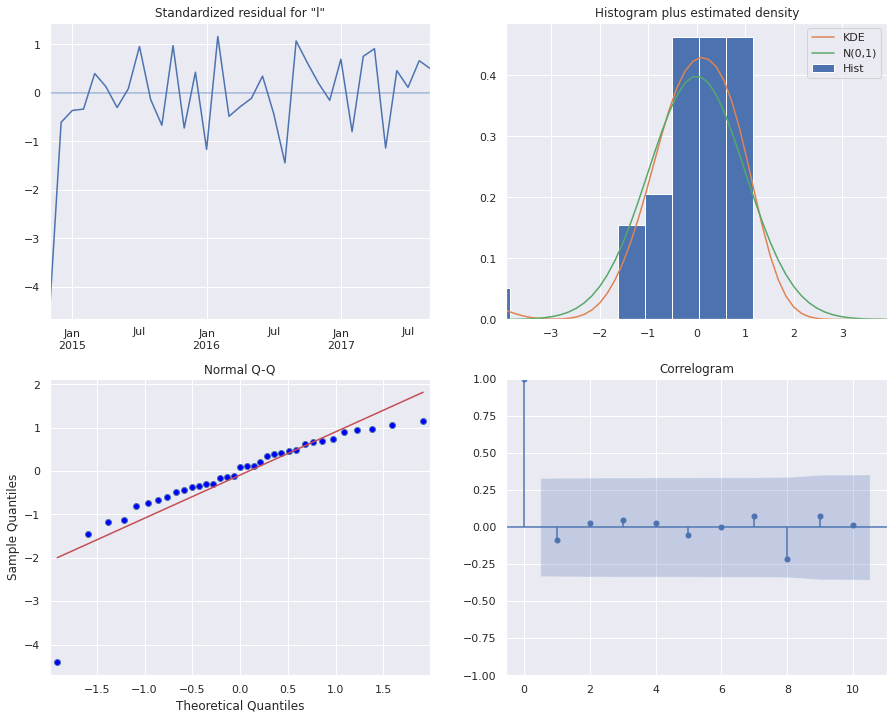

Ljung-box p-values:
[0.59649517 0.8533577  0.9385969  0.97918542 0.98910405 0.99679715
 0.99693073]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  57.310
Date:                            Sun, 27 Mar 2022   AIC                           -110.620
Time:                                    21:56:45   BIC                           -107.510
Sample:                                10-01-2013   HQIC                          -109.546
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_total_sales     0.0038      0.027      0.141      0.888      -0.049       0.056
sigma2              0.0022      0.000      5.541      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               109.69
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.21
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [104]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['log_total_sales'], order=(0,1,0),seasonal_order=(1,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [105]:
model.aic

-108.62457832878528

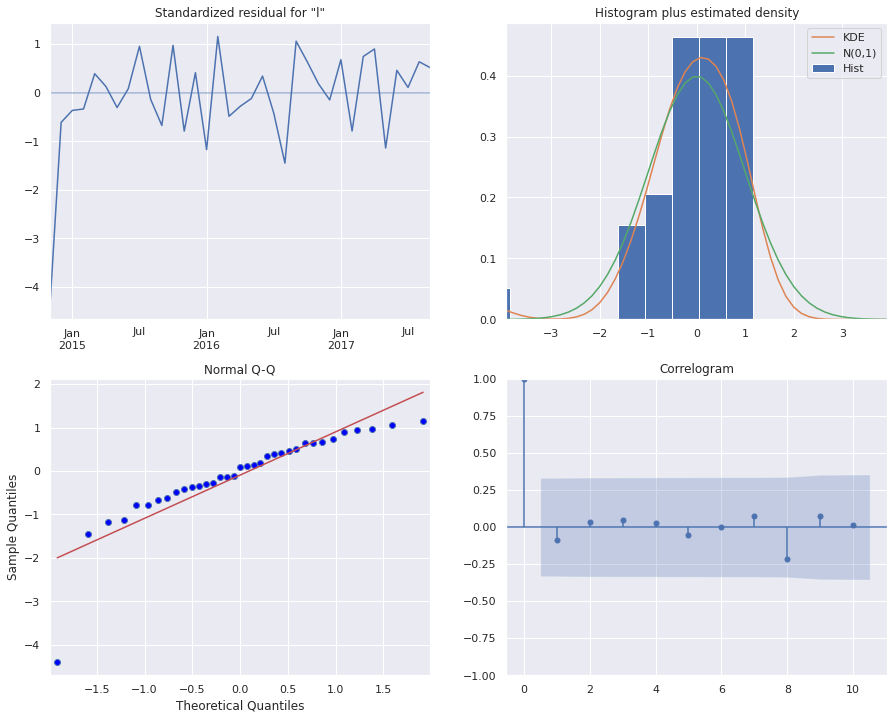

Ljung-box p-values:
[0.5897318  0.84673413 0.93612983 0.97851203 0.9887832  0.99667943
 0.99713604]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  57.312
Date:                            Sun, 27 Mar 2022   AIC                           -108.625
Time:                                    21:56:48   BIC                           -103.959
Sample:                                10-01-2013   HQIC                          -107.014
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_total_sales     0.0035      0.027      0.127      0.899      -0.050       0.057
ar.S.L12           -0.0145      0.249     -0.058      0.953      -0.502       0.473
sigma2              0.0022      0.000      5.436      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               108.54
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.20
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [107]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['log_total_sales'], order=(0,1,0),seasonal_order=(0,1,1,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [108]:
model.aic

-108.62473176218764

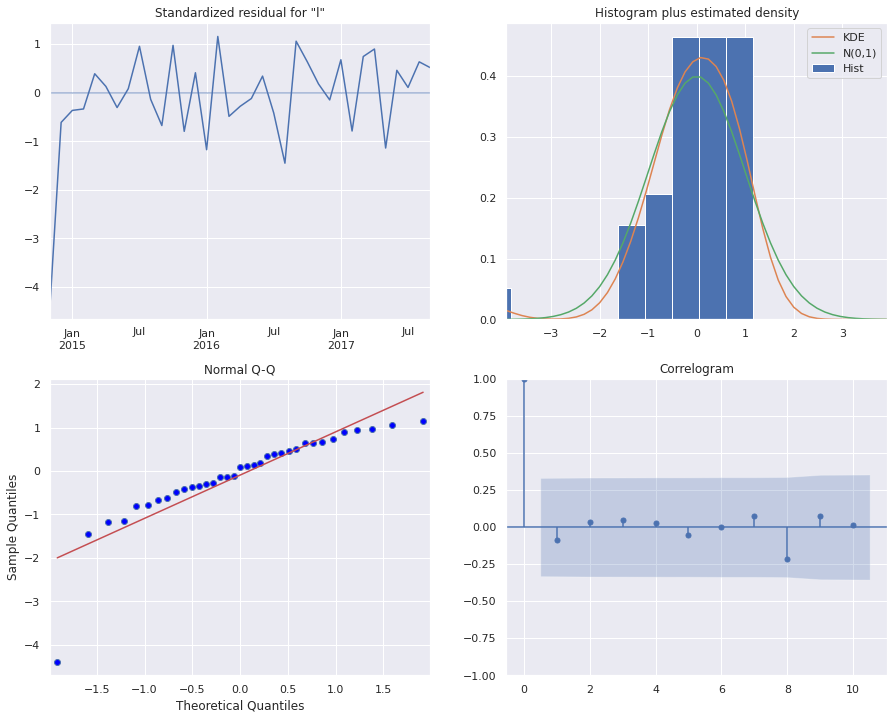

Ljung-box p-values:
[0.58907152 0.84620911 0.93588164 0.97842165 0.98871416 0.99665388
 0.9971403 ]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  57.312
Date:                              Sun, 27 Mar 2022   AIC                           -108.625
Time:                                      21:56:50   BIC                           -103.959
Sample:                                  10-01-2013   HQIC                          -107.014
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_total_sales     0.0034      0.027      0.125      0.901      -0.050       0.057
ma.S.L12           -0.0156      0.248     -0.063      0.950      -0.502       0.471
sigma2              0.0022      0.000      5.430      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               108.38
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.20
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

In [110]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['log_total_sales'], order=(0,1,0),seasonal_order=(1,1,1,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [111]:
model.aic

-106.62465806168463

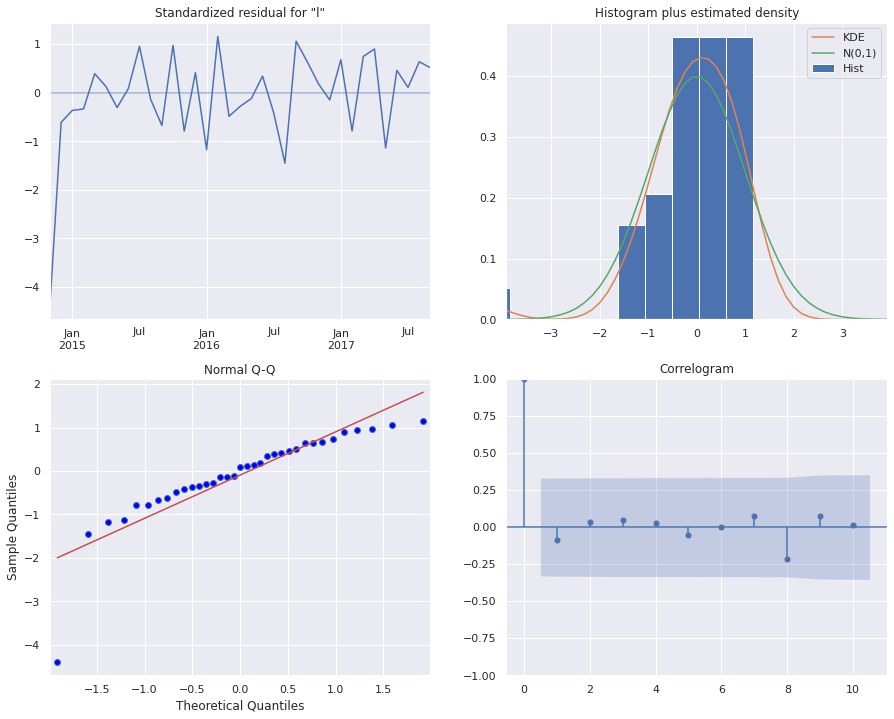

Ljung-box p-values:
[0.58949491 0.84654664 0.93603609 0.97848335 0.98876587 0.99667298
 0.99713991]


/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            log_value   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  57.312
Date:                              Sun, 27 Mar 2022   AIC                           -106.625
Time:                                      21:56:51   BIC                           -100.403
Sample:                                  10-01-2013   HQIC                          -104.477
                                       - 09-01-2017                                         
Covariance Type:                                opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
log_total_sales     0.0034      0.027      0.126      0.900      -0.050       0.057
ar.S.L12           -0.0075     62.649     -0.000      1.000    -122.797     122.782
ma.S.L12           -0.0075     62.666     -0.000      1.000    -122.830     122.815
sigma2              0.0022      0.000      5.425      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               108.50
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -2.20
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()
print("Ljung-box p-values:\n" + str(model.test_serial_correlation(method='ljungbox')[0][1]))
model.summary()

## Prediction

In [113]:
model = sm.tsa.statespace.SARIMAX(train['log_value'],exog=train['log_total_sales'], order=(0,1,0),seasonal_order=(0,1,0,12)).fit()

/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/nihar/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [114]:
p = pd.DataFrame()
p['Forecast'] = model.predict(end='2018-09-01',exog=test['log_total_sales'])[-12:].values
p['Actual'] = test['log_value'].values
p.index = test.index

Text(0, 0.5, 'Ad Spends in dollars')

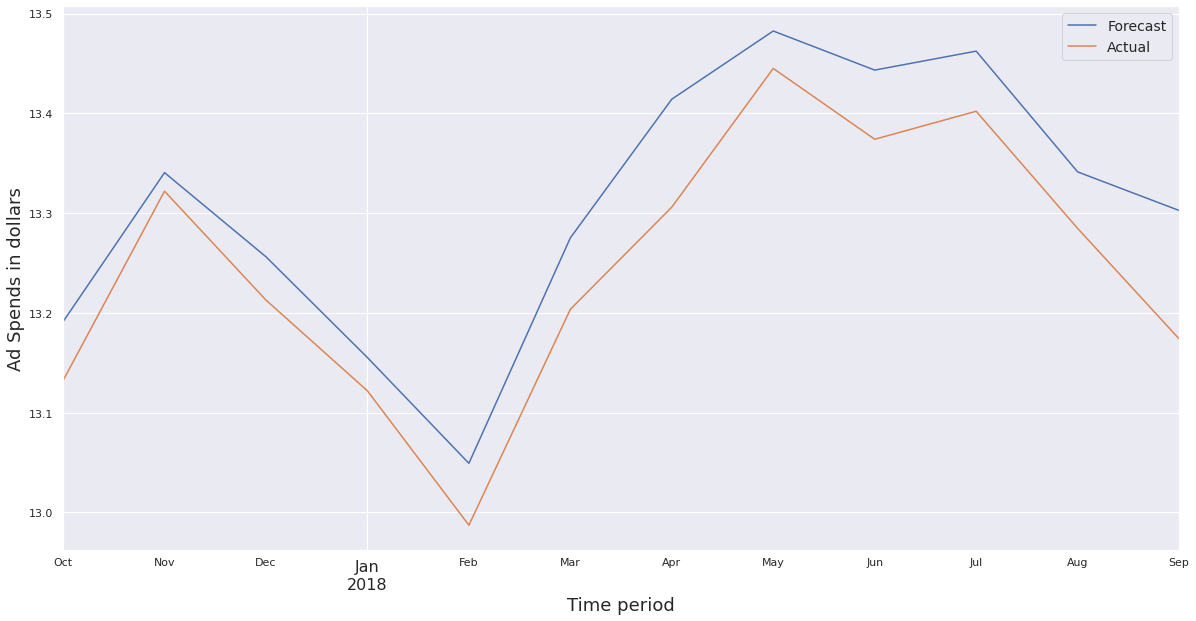

In [115]:
p['Forecast'].plot(legend=True)
p['Actual'].plot(legend=True)
plt.xticks(fontsize=16)
plt.xlabel('Time period',fontsize=18)
plt.legend(fontsize=14)
plt.ylabel('Ad Spends in dollars',fontsize=18)

In [116]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(p['Actual'], p['Forecast'])
print('MSPE: %f' % mse)

MSPE: 0.004759
